In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model


import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# Custom color palette
custom_colors = [
    '#00A5A6',  # teal
    '#E03D90',  # pink
    '#FC6538',  # orange
    '#6A3ECB',  # purple
    '#0058DC',  # blue
    '#EA8D00',  # yellow
    '#B087F4',  # lightPurple
    '#279E27',  # green
    '#009AF1',  # lightBlue
    '#015D90',  # darkBlue
    '#EA4831',  # red
    '#E1C700',  # yellow2
    '#46FFFF',  # turquoise
    '#63F039',  # lightGreen
]

sns.set_palette(custom_colors)
colors = sns.color_palette()

# === Seaborn global settings ===
sns.set_theme(
    style="whitegrid",        # or "darkgrid", "ticks", "white"
    palette=custom_colors,    # your custom color palette
    context="notebook"        # scaling for labels/titles ("paper", "notebook", "talk", "poster")
)

# === Matplotlib global settings (rcParams) ===
plt.rcParams.update({
    # Figure
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    
    # Axes
    "axes.titley": 1.02,
    "axes.titlesize": 14,
    "axes.titlelocation": 'center',
    "axes.titlepad": 0,
    "axes.labelsize": 12,
    "axes.labelpad": 10,           # spacing between axis and label
    "axes.spines.top": False,
    "axes.spines.right": False,
    
    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    # tick marks size
    "xtick.major.size": 5,
    "ytick.major.size": 5,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    
    # tick visibility
    "xtick.top": False,
    "xtick.bottom": True,
    "ytick.left": True,
    "ytick.right": False,
    
    # Legend
    "legend.fontsize": 10,
    "legend.loc": "upper left",
    "legend.frameon": True,
    "legend.borderaxespad": 0,

    
    # Lines and markers
    "lines.linewidth": 2,
    "lines.markersize": 8,
    "lines.markeredgecolor": 'auto',   # white outline (stroke)
    "lines.markeredgewidth": 0.5,   
    # title alignment left
    

    
    
    # Error bars
    "errorbar.capsize": 3,
    
    # Font
    "font.family": "Arial",
    "font.sans-serif": ["DejaVu Sans"],
    
    # Grid
    "grid.alpha": 0.3,
    "grid.linestyle": "-",
    "grid.color": "lightgray",
})


null performances after coercion: 0
after saturation filter 2408
after filter num benchmarks 2234
after merge with model versions 2230
after date filter (>= 2022-11-01) 1996
after merge with benchmark dates 1996
Original number of rows: 1996
Number of rows after aggregation: 1528


In [3]:
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.263943
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.510032

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 29, initial cost 5.7153e+01, final cost 3.6978e+00, first-order optimality 9.03e-04.


In [4]:
ref_models = [
'claude-2.0', 
'claude-3-opus-20240229',
'claude-3-7-sonnet-20250219_64K',
'claude-3-5-sonnet-20241022',
'claude-3-5-sonnet-20240620',
'claude-opus-4-20250514_16K',
'o1-2024-12-17_high',
'o1-mini-2024-09-12_high',
'o3-2025-04-16_high',
'o3-mini-2025-01-31_high',
'o4-mini-2025-04-16_high',
'text-davinci-001',
'gpt-4-0314',
'gpt-4-0613',
'gpt-4o-2024-11-20',
'gpt-4o-mini-2024-07-18',
'gpt-4.5-preview-2025-02-27',
'gpt-5-2025-08-07_high',
'claude-sonnet-4-5-20250929',
'claude-opus-4-20250514_32K',
'claude-opus-4-1-20250805_32K',
'grok-4-0709',
'text-davinci-003',
'text-davinci-002',
'text-davinci-001',
'davinci-002',
'davinci',
'gpt2-xl',
]

df_cm1[df_cm1["model"].isin(ref_models)][["model", "estimated_capability"]]

,model,estimated_capability
245,gpt-5-2025-08-07_high,2.579158
202,o3-2025-04-16_high,2.449597
33,grok-4-0709,2.436899
200,o4-mini-2025-04-16_high,2.409733
50,claude-opus-4-20250514_32K,2.287286
230,o3-mini-2025-01-31_high,2.241186
228,o1-2024-12-17_high,2.227277
195,claude-opus-4-20250514_16K,2.215830
170,claude-3-7-sonnet-20250219_64K,2.168540
65,claude-sonnet-4-5-20250929,2.127368


In [5]:
main_plot_benchmarks = ["GPQA diamond", "FrontierMath-2025-02-28-Private", "Terminal Bench", "SWE-Bench verified", "Cybench", "MMLU"]
main_plot_models = ["gemini-2.5-pro", "DeepSeek-R1", "claude-3-7-sonnet-20250219", "gpt-4o-2024-11-20", "gpt-5-2025-08-07_high", \
        "claude-sonnet-4-5-20250929", "gpt-4.5-preview-2025-02-27", "Llama-3.1-405B", "grok-4-0709", "gpt-4-0314", "phi-2"]
df_db1[df_db1["benchmark_name"].isin(main_plot_benchmarks)][["benchmark_name", "estimated_difficulty"]]

,benchmark_name,estimated_difficulty
7,MMLU,0.812983
17,GPQA diamond,1.753232
22,SWE-Bench verified,2.268687
31,Terminal Bench,2.683097
32,FrontierMath-2025-02-28-Private,2.749235
34,Cybench,3.137110


In [6]:
df_cm1[df_cm1["model"].isin(main_plot_models)][["model", "estimated_capability"]]

,model,estimated_capability
245,gpt-5-2025-08-07_high,2.579158
33,grok-4-0709,2.436899
106,gemini-2.5-pro,2.387924
65,claude-sonnet-4-5-20250929,2.127368
191,DeepSeek-R1,2.126702
227,claude-3-7-sonnet-20250219,2.052375
222,gpt-4.5-preview-2025-02-27,2.050199
110,Llama-3.1-405B,1.806426
235,gpt-4o-2024-11-20,1.740248
11,gpt-4-0314,1.587428


In [7]:
table = pd.concat(
    [
        df_db1[df_db1["benchmark_name"].isin(main_plot_benchmarks)][
            ["benchmark_name", "estimated_difficulty"]
        ].rename(columns={"benchmark_name": "item", "estimated_difficulty": "score"}),
        df_cm1[df_cm1["model"].isin(main_plot_models)][
            ["model", "estimated_capability"]
        ].rename(columns={"model": "item", "estimated_capability": "score"}),
    ],
    ignore_index=True,
)

ranked = table.sort_values("score", ascending=False).assign(
    rank=lambda df: range(1, len(df) + 1)
)[["rank", "item", "score"]]

display(ranked)

,rank,item,score
5,1,Cybench,3.137110
4,2,FrontierMath-2025-02-28-Private,2.749235
3,3,Terminal Bench,2.683097
6,4,gpt-5-2025-08-07_high,2.579158
7,5,grok-4-0709,2.436899
8,6,gemini-2.5-pro,2.387924
2,7,SWE-Bench verified,2.268687
9,8,claude-sonnet-4-5-20250929,2.127368
10,9,DeepSeek-R1,2.126702
11,10,claude-3-7-sonnet-20250219,2.052375


# Error bars

In [8]:
import numpy as np
from scipy.optimize import minimize_scalar

def logistic(x):
    """Logistic function with clipping to prevent overflow."""
    x_clipped = np.clip(x, -500, 500)
    return 1.0 / (1.0 + np.exp(-x_clipped))

def compute_loss(predictions, actuals):
    """Compute sum of squared residuals."""
    return np.sum((predictions - actuals) ** 2)

def compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for model capabilities using binary search.
    
    For each C_m, we search for how far we can push C_m in either direction
    before causing a 5% increase in loss (on the subset that C_m influences).
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: model, estimated_capability, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries for efficiency
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for model_name in df_cm1['model']:
        # Get subset of data for this model
        model_data = df1[df1['model'] == model_name].copy()
        
        if len(model_data) == 0:
            # No data for this model
            results.append({
                'model': model_name,
                'estimated_capability': capability_dict[model_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original capability
        C_original = capability_dict[model_name]
        
        # Compute original loss for this model's data
        model_data['D'] = model_data['benchmark'].map(difficulty_dict)
        model_data['alpha'] = model_data['benchmark'].map(slope_dict)
        original_predictions = logistic(model_data['alpha'] * (C_original - model_data['D']))
        original_loss = compute_loss(original_predictions, model_data['performance'])
        
        # Set acceptable loss threshold
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        # Define loss function for a given capability
        def loss_for_capability(C_test):
            predictions = logistic(model_data['alpha'] * (C_test - model_data['D']))
            return compute_loss(predictions, model_data['performance'])
        
        # Binary search for lower bound (decrease C_m)
        # Start with a reasonable search range
        search_range_lower = 5.0  # How far below to search
        C_lower = C_original - search_range_lower
        C_upper = C_original
        
        # Check if we need to expand the search range
        if loss_for_capability(C_lower) < max_loss:
            C_lower = C_original - 20.0  # Expand if needed
        
        # Binary search
        for _ in range(50):  # Max iterations
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_upper = C_mid
            else:
                C_lower = C_mid
        
        lower_bound = (C_lower + C_upper) / 2
        
        # Binary search for upper bound (increase C_m)
        C_lower = C_original
        C_upper = C_original + search_range_lower
        
        # Check if we need to expand the search range
        if loss_for_capability(C_upper) < max_loss:
            C_upper = C_original + 20.0
        
        # Binary search
        for _ in range(50):
            C_mid = (C_lower + C_upper) / 2
            loss_mid = loss_for_capability(C_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                C_lower = C_mid
            else:
                C_upper = C_mid
        
        upper_bound = (C_lower + C_upper) / 2
        
        results.append({
            'model': model_name,
            'estimated_capability': C_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': C_original - lower_bound,
            'error_plus': upper_bound - C_original
        })
    
    return pd.DataFrame(results)

def compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05):
    """
    Compute error bars for benchmark difficulties using binary search.
    
    For each D_b, after moving D_b, we re-fit α_b before evaluating the loss.
    
    Parameters:
    -----------
    df1 : DataFrame
        The main data with model, benchmark, and performance columns
    df_cm1 : DataFrame
        Model capabilities with estimated_capability column
    df_db1 : DataFrame
        Benchmark parameters with estimated_difficulty and estimated_slope columns
    loss_increase_threshold : float
        The threshold for loss increase (default 0.05 for 5%)
    
    Returns:
    --------
    DataFrame with columns: benchmark_name, estimated_difficulty, lower_bound, upper_bound, error_minus, error_plus
    """
    results = []
    
    # Create lookup dictionaries
    capability_dict = dict(zip(df_cm1['model'], df_cm1['estimated_capability']))
    difficulty_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_difficulty']))
    slope_dict = dict(zip(df_db1['benchmark_name'], df_db1['estimated_slope']))
    
    for benchmark_name in df_db1['benchmark_name']:
        # Get subset of data for this benchmark
        bench_data = df1[df1['benchmark'] == benchmark_name].copy()
        
        if len(bench_data) == 0:
            results.append({
                'benchmark_name': benchmark_name,
                'estimated_difficulty': difficulty_dict[benchmark_name],
                'lower_bound': np.nan,
                'upper_bound': np.nan,
                'error_minus': np.nan,
                'error_plus': np.nan
            })
            continue
        
        # Get original difficulty and slope
        D_original = difficulty_dict[benchmark_name]
        alpha_original = slope_dict[benchmark_name]
        
        # Add model capabilities to benchmark data
        bench_data['C'] = bench_data['model'].map(capability_dict)
        
        # Compute original loss
        original_predictions = logistic(alpha_original * (bench_data['C'] - D_original))
        original_loss = compute_loss(original_predictions, bench_data['performance'])
        
        max_loss = original_loss * (1 + loss_increase_threshold)
        
        def refit_alpha_and_compute_loss(D_test):
            """
            For a given D_test, find the optimal alpha and return the loss.
            """
            def loss_for_alpha(alpha):
                if alpha <= 0:
                    return 1e10  # Penalty for invalid alpha
                predictions = logistic(alpha * (bench_data['C'] - D_test))
                return compute_loss(predictions, bench_data['performance'])
            
            # Optimize alpha (constrained to be positive)
            result = minimize_scalar(loss_for_alpha, bounds=(0.01, 20.0), method='bounded')
            return result.fun
        
        # Binary search for lower bound
        search_range = 5.0
        D_lower = D_original - search_range
        D_upper = D_original
        
        if refit_alpha_and_compute_loss(D_lower) < max_loss:
            D_lower = D_original - 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_upper = D_mid
            else:
                D_lower = D_mid
        
        lower_bound = (D_lower + D_upper) / 2
        
        # Binary search for upper bound
        D_lower = D_original
        D_upper = D_original + search_range
        
        if refit_alpha_and_compute_loss(D_upper) < max_loss:
            D_upper = D_original + 20.0
        
        for _ in range(50):
            D_mid = (D_lower + D_upper) / 2
            loss_mid = refit_alpha_and_compute_loss(D_mid)
            
            if abs(loss_mid - max_loss) < 1e-6 * original_loss:
                break
            
            if loss_mid < max_loss:
                D_lower = D_mid
            else:
                D_upper = D_mid
        
        upper_bound = (D_lower + D_upper) / 2
        
        results.append({
            'benchmark_name': benchmark_name,
            'estimated_difficulty': D_original,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'error_minus': D_original - lower_bound,
            'error_plus': upper_bound - D_original
        })
    
    return pd.DataFrame(results)

# Compute error bars
print("Computing error bars for model capabilities...")
capability_errors = compute_capability_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nComputing error bars for benchmark difficulties...")
difficulty_errors = compute_difficulty_error_bars(df1, df_cm1, df_db1, loss_increase_threshold=0.05)

print("\nDone! Error bars computed.")
print(f"\nSample capability errors:")
print(capability_errors.head(10))
print(f"\nSample difficulty errors:")
print(difficulty_errors.head(10))


Computing error bars for model capabilities...

Computing error bars for benchmark difficulties...

Done! Error bars computed.

Sample capability errors:
                                     model  estimated_capability  lower_bound  \
0                gpt-5-pro-2025-10-06_high              2.597041     2.589033   
1                             gpt-5.1_high              2.581826     2.565191   
2                    gpt-5-2025-08-07_high              2.579158     2.559431   
3  gemini-2.5-deep-think-2025-08-01-webapp              2.557550     2.554620   
4                  gpt-5-2025-08-07_medium              2.535862     2.504917   
5                 o3-pro-2025-06-10_medium              2.505983     2.484033   
6                           gpt-5.1_medium              2.500026     2.488423   
7                   o3-pro-2025-06-10_high              2.487383     2.486306   
8                              gpt-5-codex              2.465579     2.460064   
9                       o3-2025-04-1

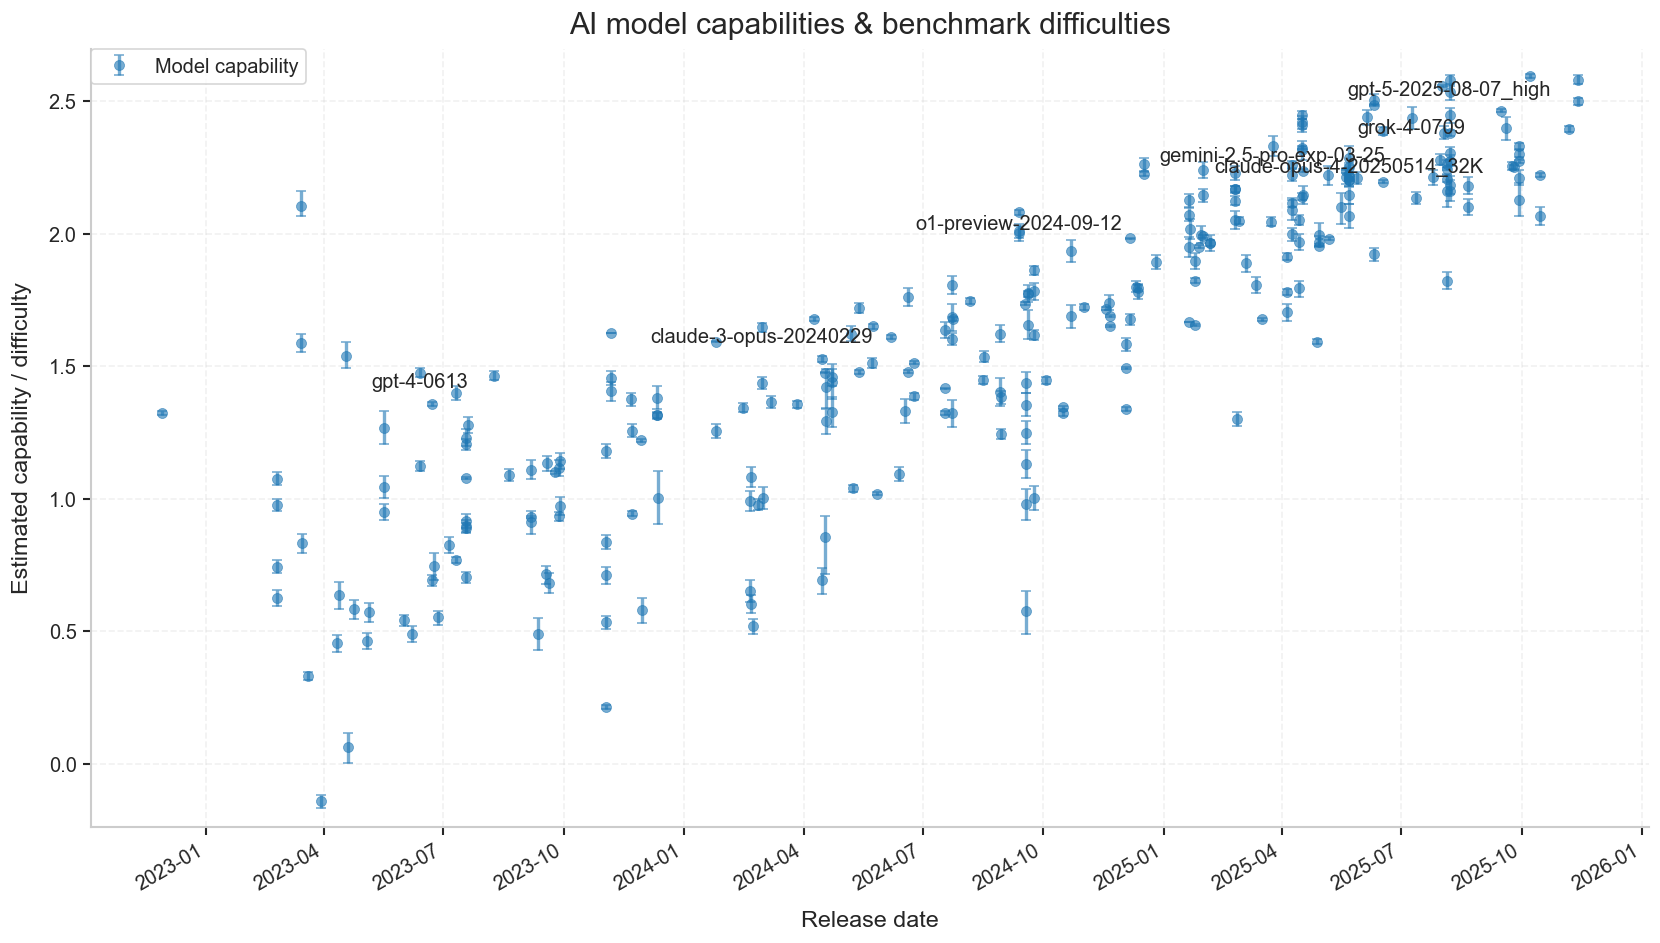


ERROR BAR STATISTICS

Model Capabilities:
  Mean error (minus): 0.0254
  Mean error (plus):  0.0250
  Median error (minus): 0.0242
  Median error (plus):  0.0241
  Max error (minus): 0.1390
  Max error (plus):  0.1020


In [9]:
# ── PLOT WITH ERROR BARS ──────────────────────────────────────────────────

# Merge error bars with the original data
cap_df_with_errors = df_cm1.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)
# bench_df_with_errors = df_db1.merge(
#     difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
#     on='benchmark_name', 
#     how='left'
# )

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

# bench_df_with_errors["date_obj"] = pd.to_datetime(bench_df_with_errors["benchmark_release_date"])
# bench_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
# bench_dates_num = mdates.date2num(bench_df_with_errors["date_obj"])
# bench_values = bench_df_with_errors["estimated_difficulty"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with error bars
ax.errorbar(cap_dates_num, cap_values,
            yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
            fmt='o', markersize=6, capsize=3, capthick=1,
            color='tab:blue', ecolor='tab:blue', alpha=0.6,
            label='Model capability')

# ax.errorbar(bench_dates_num, bench_values,
#             yerr=[bench_df_with_errors["error_minus"], bench_df_with_errors["error_plus"]],
#             fmt='s', markersize=6, capsize=3, capthick=1,
#             color='tab:orange', ecolor='tab:orange', alpha=0.6,
#             label='Benchmark difficulty')

# Annotate selected points (same as before)
annotate_models = {
    "gpt-5-2025-08-07_high",
    "claude-opus-4-20250514_32K",
    "grok-4-0709",
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df_with_errors["model"])):
    if name not in annotate_models:
        continue
    y_offset = 0.05 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# annotate_benchmarks = {
#     "MMLU",
#     "Winogrande",
#     "GPQA diamond",
#     "OSWorld",
#     "Cybench",
#     "Terminal Bench",
#     "TriviaQA",
# }

# for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df_with_errors["benchmark_name"])):
#     if name not in annotate_benchmarks:
#         continue
#     y_offset = 0.05 if i % 2 == 0 else -0.05
#     va = 'bottom' if i % 2 == 0 else 'top'
#     ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
#                 textcoords='offset points', ha='center', va=va, fontsize=12)

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

min_y = min(cap_values.min(), cap_values.min()) - 0.1
max_y = max(cap_values.max(), cap_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/model_fit/capabilities_with_error_bars.pdf")
plt.show()

# Print some statistics about error bars
print("\n" + "="*60)
print("ERROR BAR STATISTICS")
print("="*60)
print(f"\nModel Capabilities:")
print(f"  Mean error (minus): {capability_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {capability_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {capability_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {capability_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {capability_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {capability_errors['error_plus'].max():.4f}")

# print(f"\nBenchmark Difficulties:")
# print(f"  Mean error (minus): {difficulty_errors['error_minus'].mean():.4f}")
# print(f"  Mean error (plus):  {difficulty_errors['error_plus'].mean():.4f}")
# print(f"  Median error (minus): {difficulty_errors['error_minus'].median():.4f}")
# print(f"  Median error (plus):  {difficulty_errors['error_plus'].median():.4f}")
# print(f"  Max error (minus): {difficulty_errors['error_minus'].max():.4f}")
# print(f"  Max error (plus):  {difficulty_errors['error_plus'].max():.4f}")


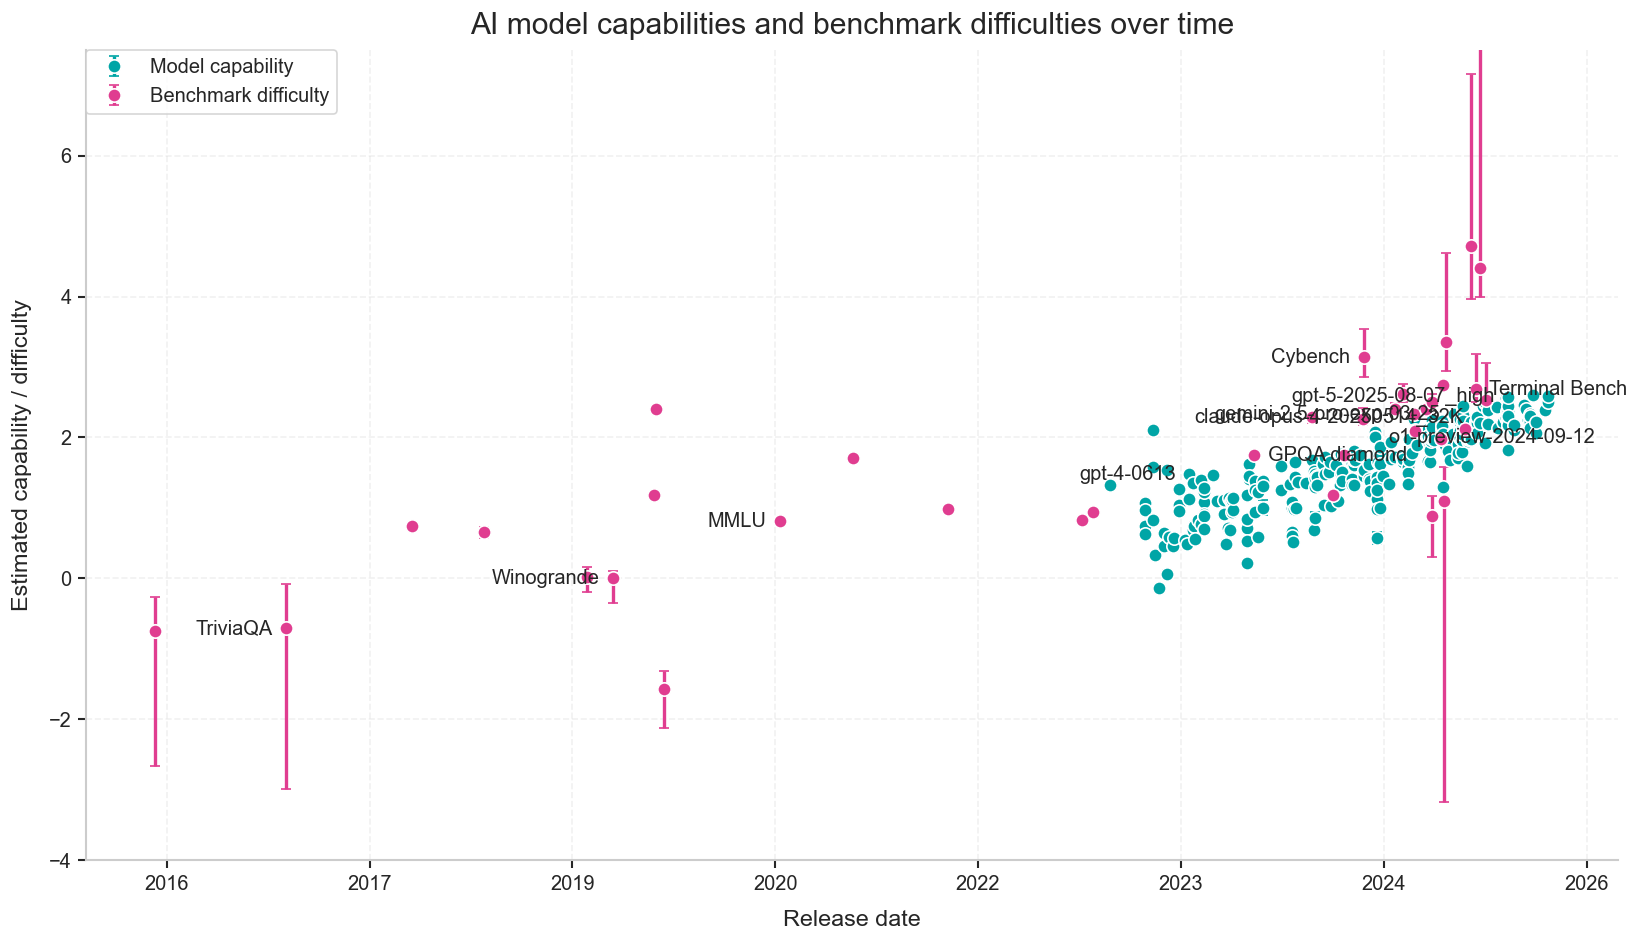


ERROR BAR STATISTICS

Model Capabilities:
  Mean error (minus): 0.0254
  Mean error (plus):  0.0250
  Median error (minus): 0.0242
  Median error (plus):  0.0241
  Max error (minus): 0.1390
  Max error (plus):  0.1020

Benchmark Difficulties:
  Mean error (minus): 0.3592
  Mean error (plus):  0.3144
  Median error (minus): 0.0752
  Median error (plus):  0.0551
  Max error (minus): 4.2634
  Max error (plus):  3.2577


In [10]:
# ── PLOT WITH ERROR BARS ──────────────────────────────────────────────────

# Merge error bars with the original data
cap_df_with_errors = df_cm1.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)
bench_df_with_errors = df_db1.merge(
    difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
    on='benchmark_name', 
    how='left'
)

# Prepare data
cap_df_with_errors["date_obj"] = pd.to_datetime(cap_df_with_errors["date"])
cap_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df_with_errors["date_obj"])
cap_values = cap_df_with_errors["estimated_capability"]

bench_df_with_errors["date_obj"] = pd.to_datetime(bench_df_with_errors["benchmark_release_date"])
bench_df_with_errors.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df_with_errors["date_obj"])
bench_values = bench_df_with_errors["estimated_difficulty"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with error bars
ax.errorbar(cap_dates_num, cap_values,
            yerr=[cap_df_with_errors["error_minus"], cap_df_with_errors["error_plus"]],
            fmt='o', markersize=8, capsize=3, capthick=1, markeredgewidth=1, markeredgecolor='white',
            color=colors[0], ecolor=colors[0], alpha=1,
            label='Model capability')

ax.errorbar(bench_dates_num, bench_values,
            yerr=[bench_df_with_errors["error_minus"], bench_df_with_errors["error_plus"]],
            fmt='o', markersize=8, capsize=3, capthick=1, markeredgewidth=1, markeredgecolor='white',
            color=colors[1], ecolor=colors[1], alpha=1,
            label='Benchmark difficulty')

# Annotate selected points (same as before)
annotate_models = {
    "gpt-5-2025-08-07_high",
    "claude-opus-4-20250514_32K",
    # "grok-4-0709",
    "gpt-4-0613",
    # "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}


annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    # "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}
# helper for left/right non-overlapping placement
def side_offset(i, x_offset=8, y_offset=0):
    """Alternate left/right; return (dx, ha, va, dy)."""
    if i % 2 == 0:
        # place RIGHT of point
        return (x_offset, 'left', 'center', y_offset)
    else:
        # place LEFT of point
        return (-x_offset, 'right', 'center', -y_offset)


# Annotate selected models
for i, (d, y, name) in enumerate(
    zip(cap_dates_num, cap_values, cap_df_with_errors["model"])
):
    if name not in annotate_models:
        continue

    dx, ha, va, dy = side_offset(i)
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=12
    )


# Annotate selected benchmarks
for i, (d, y, name) in enumerate(
    zip(bench_dates_num, bench_values, bench_df_with_errors["benchmark_name"])
):
    if name not in annotate_benchmarks:
        continue

    dx, ha, va, dy = side_offset(i)
    ax.annotate(
        name,
        xy=(d, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=12
    )

# Axes cosmetics
ax.set_xlabel("Release date", fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities and benchmark difficulties over time", fontsize=18)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.tick_params(axis='x', rotation=0)

min_y = -4
max_y = 7.5
ax.set_ylim(min_y, max_y)

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/model_fit/capabilities_and_benchmarks_with_error_bars_g1.pdf")
# plt.savefig("outputs/figures/figure-1.svg", format="svg")

plt.show()

# Print some statistics about error bars
print("\n" + "="*60)
print("ERROR BAR STATISTICS")
print("="*60)
print(f"\nModel Capabilities:")
print(f"  Mean error (minus): {capability_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {capability_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {capability_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {capability_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {capability_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {capability_errors['error_plus'].max():.4f}")

print(f"\nBenchmark Difficulties:")
print(f"  Mean error (minus): {difficulty_errors['error_minus'].mean():.4f}")
print(f"  Mean error (plus):  {difficulty_errors['error_plus'].mean():.4f}")
print(f"  Median error (minus): {difficulty_errors['error_minus'].median():.4f}")
print(f"  Median error (plus):  {difficulty_errors['error_plus'].median():.4f}")
print(f"  Max error (minus): {difficulty_errors['error_minus'].max():.4f}")
print(f"  Max error (plus):  {difficulty_errors['error_plus'].max():.4f}")


# Growth rate

Annual growth rate: 0.4150
95% CI for slope: [0.3695, 0.4604]
R^2: 0.9524


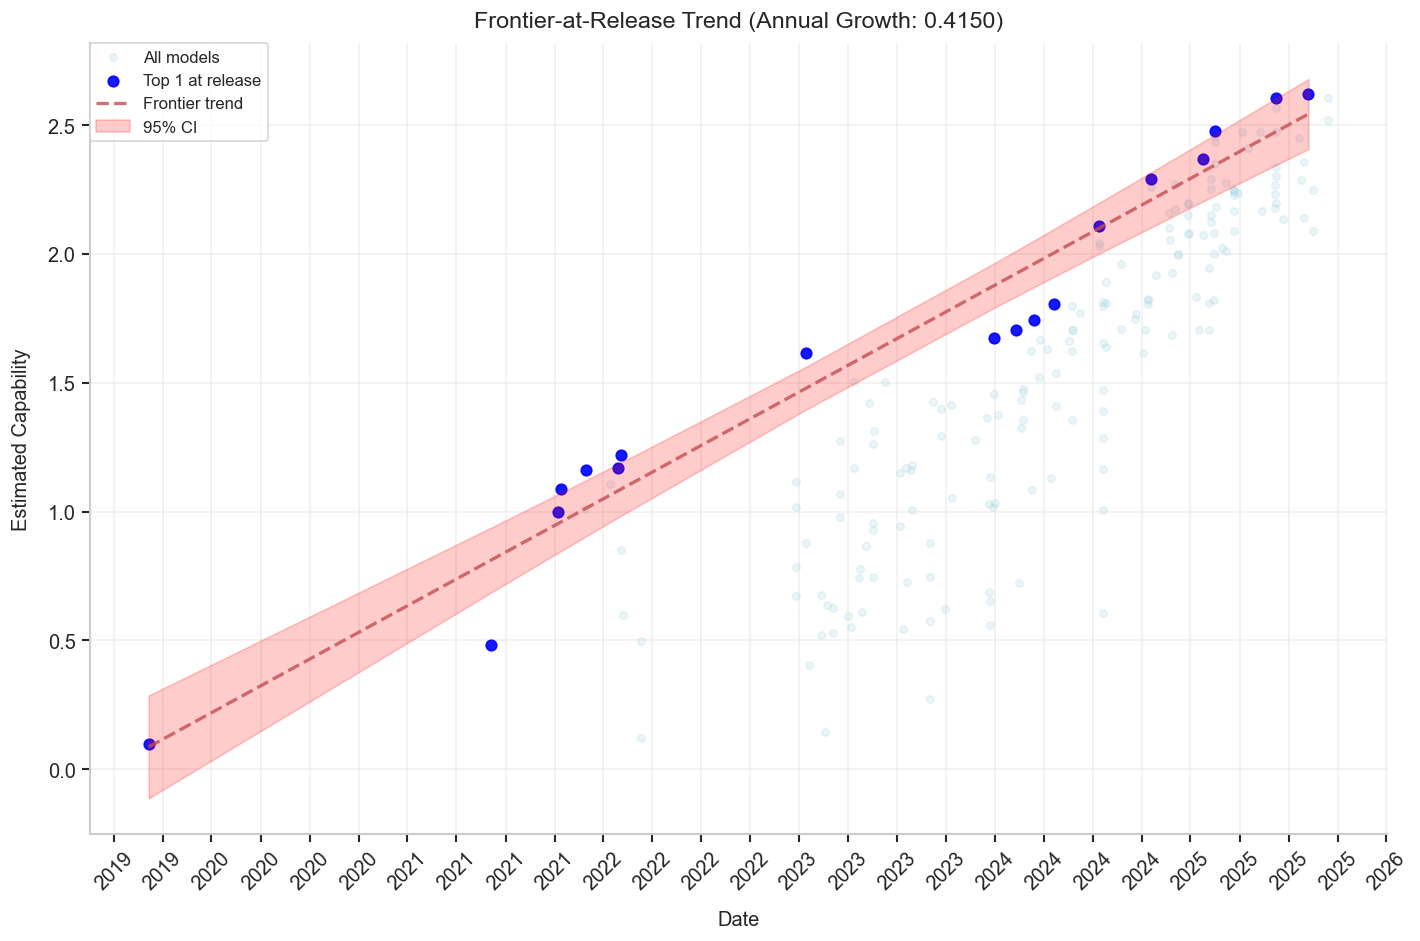

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

# Identify models that were SOTA (top-N) at their release and fit a trend
TOP_N_AT_RELEASE = 1  # change to >1 if you want top-N frontier, not strict SOTA

# Prepare data
df_all = df_cm1.copy()
# Ensure datetime
if 'date_obj' not in df_all.columns or not np.issubdtype(df_all['date_obj'].dtype, np.datetime64):
    df_all['date_obj'] = pd.to_datetime(df_all['date'])

df_all = df_all.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows = []
for _, row in df_all.iterrows():
    release_date = row['date_obj']
    available = df_all[df_all['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows.append(row)

df_frontier = pd.DataFrame(frontier_rows).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier) >= 2:
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)

    # statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    predictions = model_sm.get_prediction(X_sm)
    ci_lower = predictions.conf_int()[:, 0]
    ci_upper = predictions.conf_int()[:, 1]
    
    # Print with CI
    print(f"Annual growth rate: {slope_per_year:.4f}")
    print(f"95% CI for slope: [{model_sm.params[1]*365.25 - 1.96*model_sm.bse[1]*365.25:.4f}, "
          f"{model_sm.params[1]*365.25 + 1.96*model_sm.bse[1]*365.25:.4f}]")
    print(f"R^2: {r2:.4f}")
    
    # Plot with confidence bands
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(df_all['date_obj'], df_all['estimated_capability'], 
               alpha=0.25, s=20, label='All models', color='lightblue')
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
               alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')
    ax.plot(df_frontier['date_obj'], lr.predict(X), 'r--', alpha=0.8, label='Frontier trend')
    
    # Add confidence band
    ax.fill_between(df_frontier['date_obj'], ci_lower, ci_upper, 
                     alpha=0.2, color='red', label='95% CI')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier-at-Release Trend (Annual Growth: {slope_per_year:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("outputs/model_fit/frontier_at_release_trend_including_old_data.pdf", dpi=300, bbox_inches='tight')
    plt.show()

else:
    lr = None
    slope_per_year = np.nan
    r2 = np.nan

# print("SOTA-at-release points:", len(df_frontier))
# print(f"Annual growth rate (slope): {slope_per_year:.4f}")
# print(f"R^2: {r2:.4f}")
# if len(df_frontier) > 0:
#     print(f"Span: {df_frontier.iloc[0]['date']} {df_frontier.iloc[-1]['date']}")

# # Plot: all points, frontier points, and trendline
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.scatter(df_all['date_obj'], df_all['estimated_capability'], alpha=0.25, s=20, label='All models', color='lightblue')
# ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')

# if lr is not None:
#     X_plot = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
#     y_pred = lr.predict(X_plot)
#     ax.plot(df_frontier['date_obj'], y_pred, 'r--', alpha=0.8, label='Frontier trend')

# ax.set_xlabel('Date')
# ax.set_ylabel('Estimated Capability')
# ax.set_title('Frontier-at-Release Trend and Annual Growth Rate')
# ax.grid(True, alpha=0.3)
# ax.legend()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


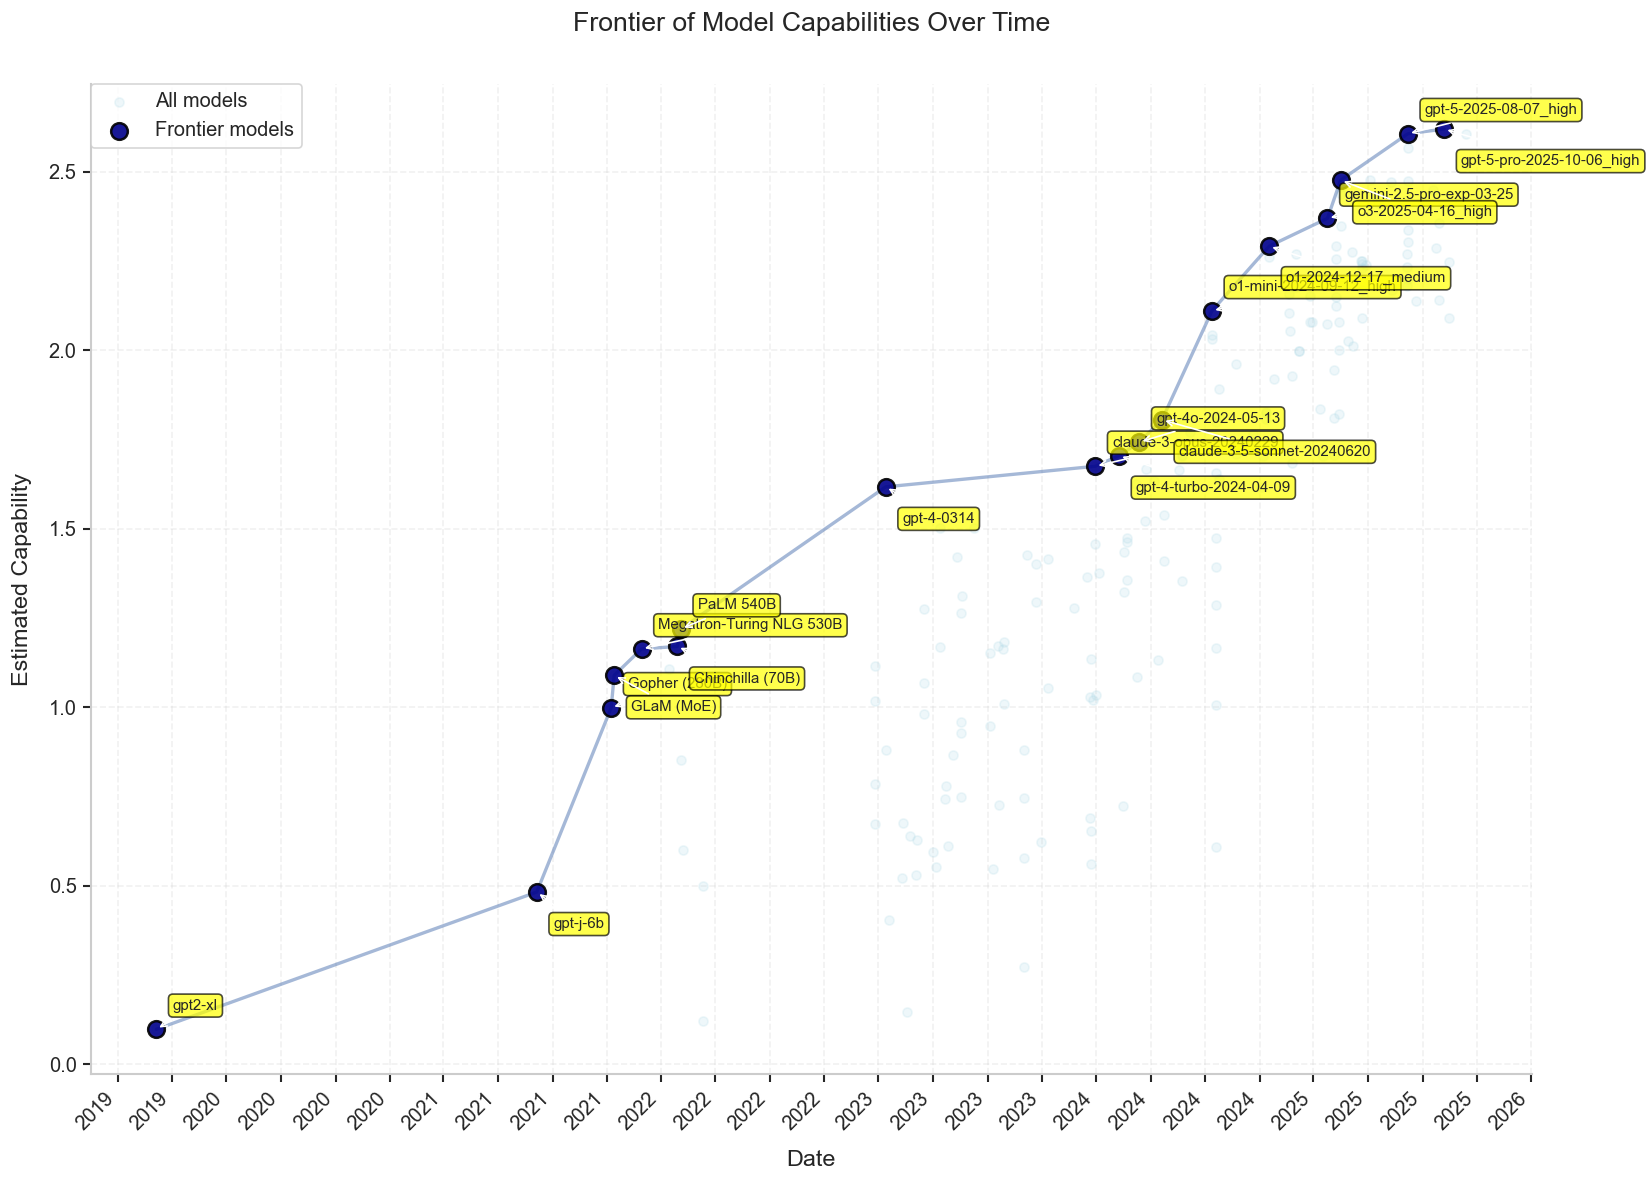


Frontier Models (SOTA at release):
2019-11-05: gpt2-xl                                       (capability: 0.0973)
2021-08-05: gpt-j-6b                                      (capability: 0.4818)
2021-12-08: Gopher (280B)                                 (capability: 0.9981)
2021-12-13: GLaM (MoE)                                    (capability: 1.0890)
2022-01-28: Megatron-Turing NLG 530B                      (capability: 1.1630)
2022-03-29: Chinchilla (70B)                              (capability: 1.1699)
2022-04-04: PaLM 540B                                     (capability: 1.2189)
2023-03-14: gpt-4-0314                                    (capability: 1.6171)
2024-02-29: claude-3-opus-20240229                        (capability: 1.6748)
2024-04-09: gpt-4-turbo-2024-04-09                        (capability: 1.7046)
2024-05-13: gpt-4o-2024-05-13                             (capability: 1.7426)
2024-06-20: claude-3-5-sonnet-20240620                    (capability: 1.8050)
2024-09-12: o1-m

In [9]:
# Plot frontier of model capabilities over time with model names
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Use the frontier data computed in the previous cell
if len(df_frontier) > 0:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all models in light color
    ax.scatter(df_all['date_obj'], df_all['estimated_capability'], 
               alpha=0.2, s=30, label='All models', color='lightblue', zorder=1)
    
    # Plot frontier models prominently
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
               alpha=0.9, s=100, label='Frontier models', color='darkblue', 
               edgecolors='black', linewidths=1.5, zorder=3)
    
    # Draw line connecting frontier points
    ax.plot(df_frontier['date_obj'], df_frontier['estimated_capability'], 
            'b-', alpha=0.5, linewidth=2, zorder=2)
    
    # Annotate each frontier model with its name
    for idx, row in df_frontier.iterrows():
        # Alternate text position to avoid overlap
        xytext_offset = (10, 10) if idx % 2 == 0 else (10, -15)
        va = 'bottom' if idx % 2 == 0 else 'top'
        
        ax.annotate(row['model'], 
                   xy=(row['date_obj'], row['estimated_capability']),
                   xytext=xytext_offset,
                   textcoords='offset points',
                   fontsize=9,
                   ha='left',
                   va=va,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1))
    
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Estimated Capability', fontsize=14)
    ax.set_title('Frontier of Model Capabilities Over Time', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=12, loc='upper left')
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig("outputs/notebooks/frontier_capabilities_over_time.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print frontier models
    print("\nFrontier Models (SOTA at release):")
    print("="*80)
    for idx, row in df_frontier.iterrows():
        print(f"{row['date']}: {row['model']:45s} (capability: {row['estimated_capability']:.4f})")
    
    print(f"\nTotal frontier models: {len(df_frontier)}")
else:
    print("No frontier data available. Please run the previous cell first.")

# Checking fit

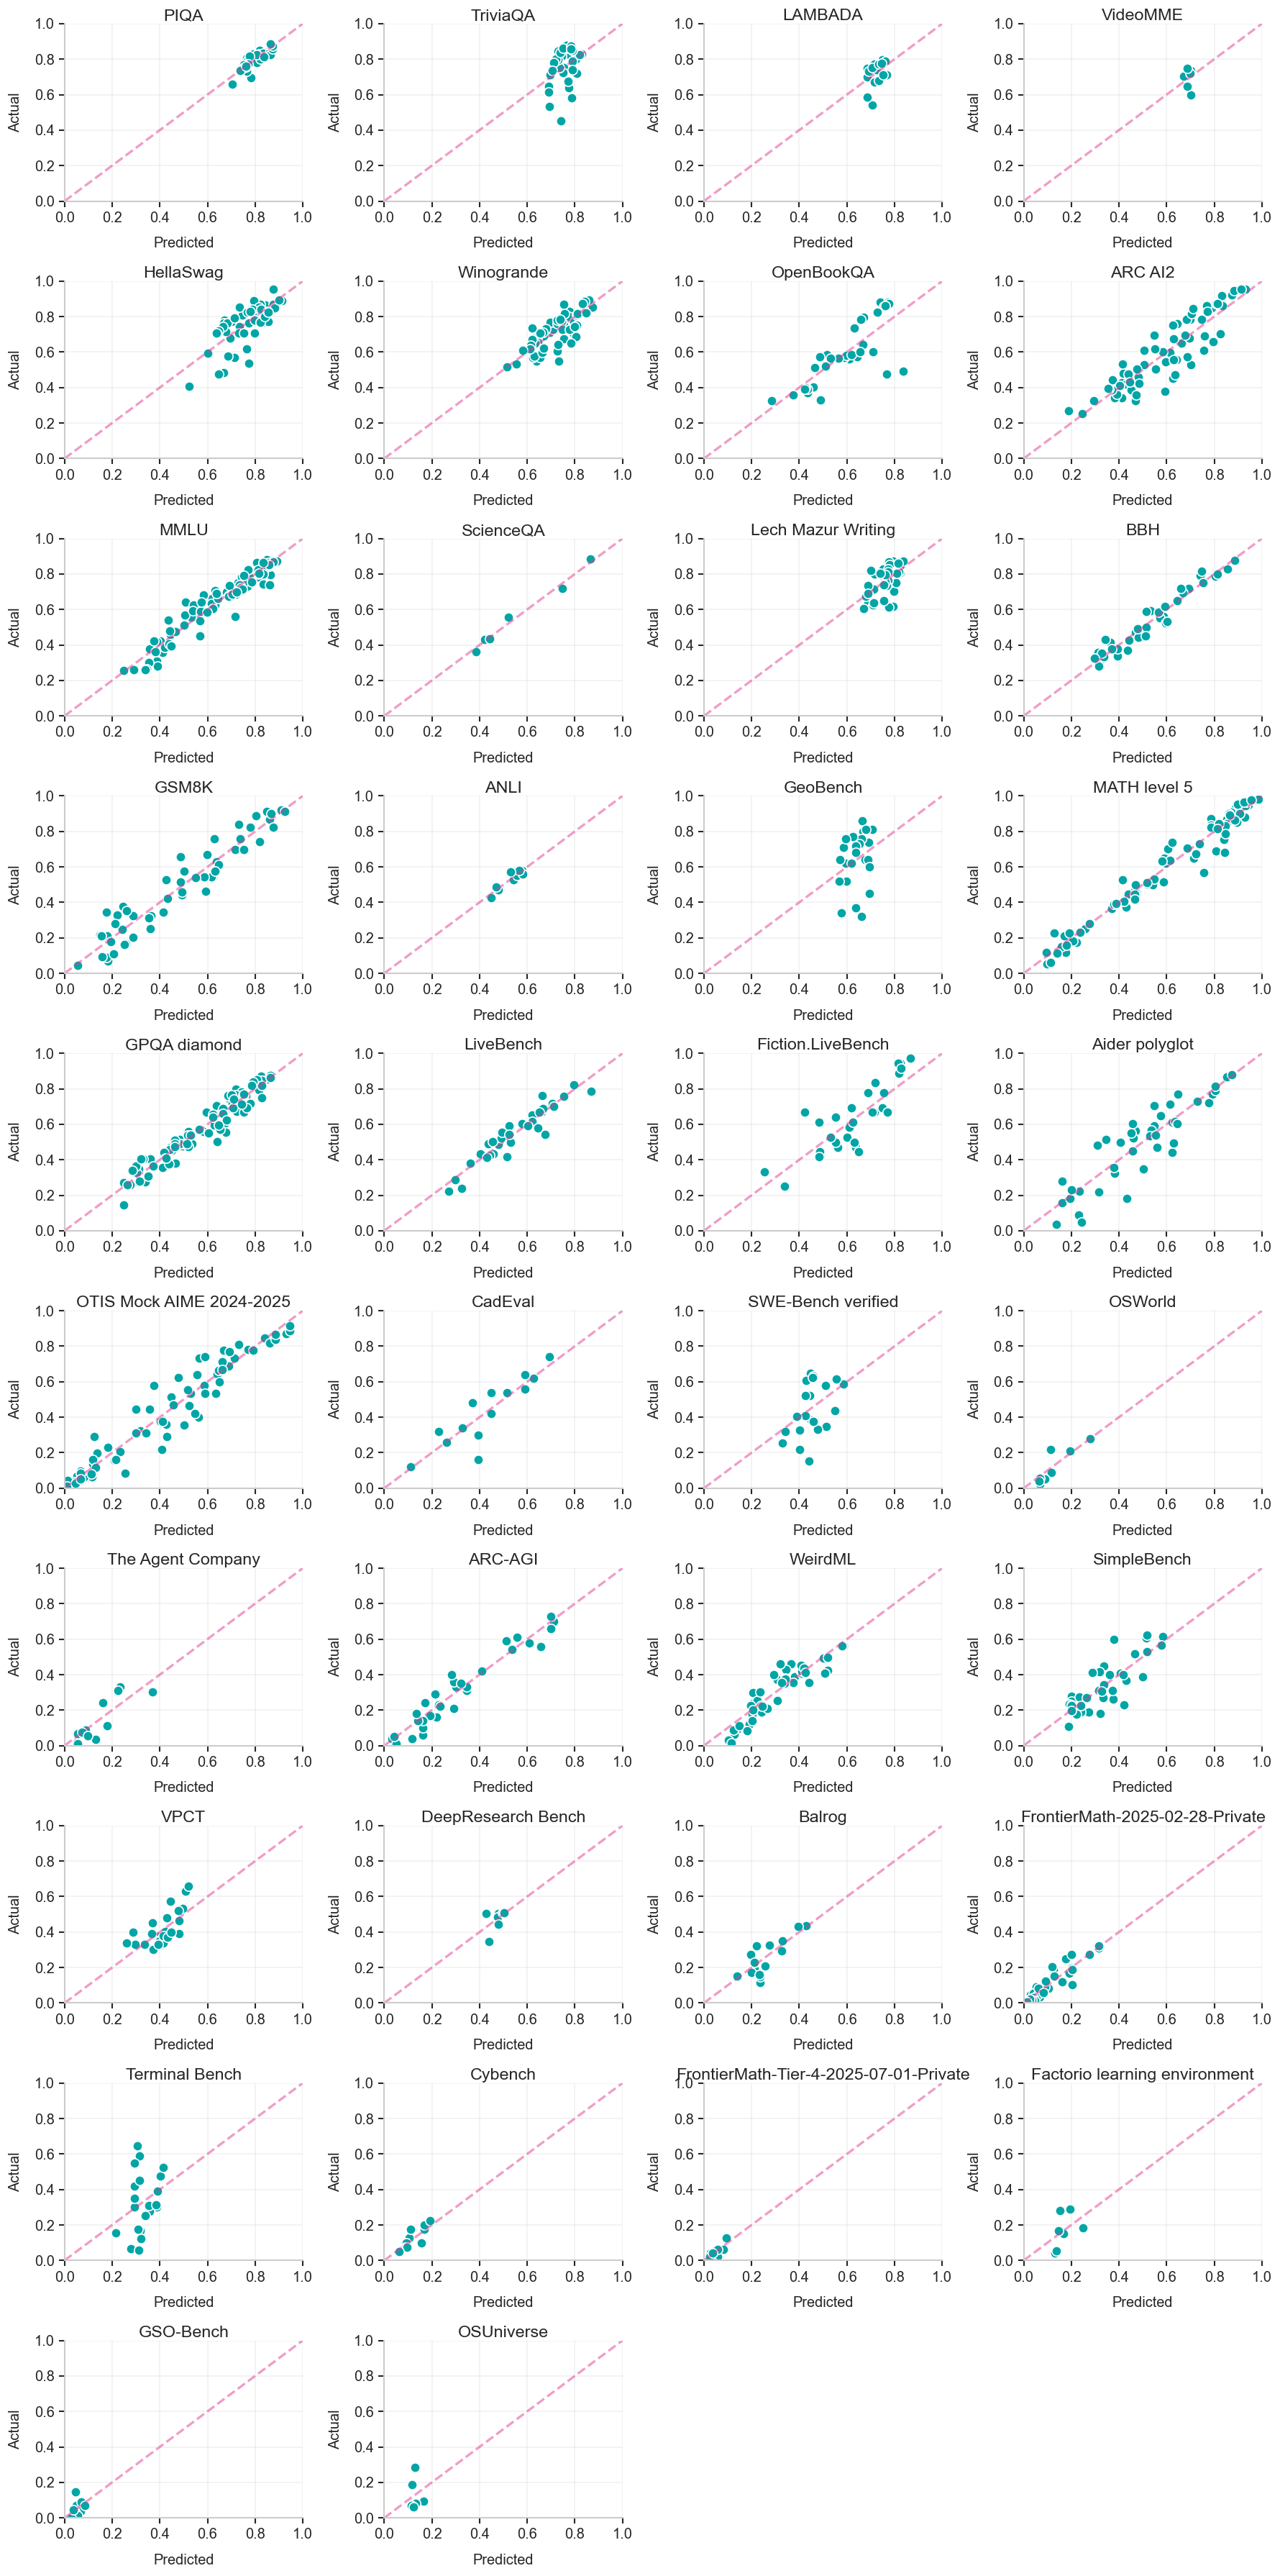

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# Get unique benchmarks
benchmarks = df_db1['benchmark_name'].unique()

# Create subplots
n_benchmarks = len(benchmarks)
n_cols = 4
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Loop through each benchmark
for idx, benchmark in enumerate(benchmarks):
    ax = axes[idx]
    
    # Get data for this benchmark
    bench_data = df1[df1['benchmark'] == benchmark].copy()
    
    # Get benchmark parameters
    bench_params = df_db1[df_db1['benchmark_name'] == benchmark].iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_cm1[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Plot
    ax.scatter(bench_data['predicted'], bench_data['performance'], alpha=1, s=64, edgecolors='white')
    ax.plot([0, 1], [0, 1], '--', alpha=0.5, color=colors[1])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(benchmark)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(n_benchmarks, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig("outputs/model_fit/benchmark_fit_scatter_grid.pdf", dpi=300, bbox_inches='tight')
# plt.savefig('outputs/figures/figure-19.svg', format='svg')

plt.show()

In [11]:
import plotly.graph_objects as go

def plot_benchmark_performance_interactive(benchmark_name, df_data=df1, df_capabilities=df_cm1, df_benchmarks=df_db1):
    """
    Create an interactive plotly scatter plot comparing actual vs predicted performance
    for a specific benchmark with model names shown on hover.
    
    Parameters:
    -----------
    benchmark_name : str
        Name of the benchmark to plot
    df_data : DataFrame
        DataFrame containing performance data (default: df1)
    df_capabilities : DataFrame
        DataFrame containing model capabilities (default: df_cm1)
    df_benchmarks : DataFrame
        DataFrame containing benchmark parameters (default: df_db1)
    """
    
    def logistic(x):
        return 1.0 / (1.0 + np.exp(-x))
    
    # Get data for this benchmark
    bench_data = df_data[df_data['benchmark'] == benchmark_name].copy()
    
    if len(bench_data) == 0:
        print(f"No data found for benchmark: {benchmark_name}")
        print(f"Available benchmarks: {sorted(df_data['benchmark'].unique())}")
        return
    
    # Get benchmark parameters
    bench_params_df = df_benchmarks[df_benchmarks['benchmark_name'] == benchmark_name]
    if len(bench_params_df) == 0:
        print(f"No parameters found for benchmark: {benchmark_name}")
        return
    
    bench_params = bench_params_df.iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_capabilities[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Create the scatter plot
    fig = go.Figure()
    
    # Add scatter points
    fig.add_trace(go.Scatter(
        x=bench_data['predicted'],
        y=bench_data['performance'],
        mode='markers',
        marker=dict(
            size=8,
            color='blue',
            opacity=0.6,
            line=dict(width=0.5, color='white')
        ),
        text=bench_data['model'],
        hovertemplate='<b>%{text}</b><br>' +
                      'Predicted: %{x:.3f}<br>' +
                      'Actual: %{y:.3f}<br>' +
                      '<extra></extra>',
        name='Models'
    ))
    
    # Add diagonal line (perfect prediction)
    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(color='red', dash='dash', width=2),
        name='Perfect Prediction',
        hovertemplate='<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f'Actual vs Predicted Performance: {benchmark_name}<br>' +
                 f'<sub>Difficulty: {D:.3f}, Slope: {alpha:.3f}</sub>',
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title='Predicted Performance',
            range=[0, 1],
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Actual Performance',
            range=[0, 1],
            gridcolor='lightgray'
        ),
        width=700,
        height=700,
        hovermode='closest',
        plot_bgcolor='white',
        showlegend=True
    )
    
    # fig.write_image("outputs/notebooks/benchmark_performance_interactive_swe_bench.pdf")
    fig.show()
    
    # Print some statistics
    residuals = bench_data['performance'] - bench_data['predicted']
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    
    print(f"\nBenchmark: {benchmark_name}")
    print(f"Number of models: {len(bench_data)}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")


# Example usage - change the benchmark name to plot different benchmarks
# Available benchmarks can be found in df_db1['benchmark_name'].unique()
plot_benchmark_performance_interactive('SWE-Bench verified')

# Uncomment to see all available benchmarks:
# print("\nAvailable benchmarks:")
# for benchmark in sorted(df_db1['benchmark_name'].unique()):
#     print(f"  - {benchmark}")



Benchmark: SWE-Bench verified
Number of models: 22
RMSE: 0.1322
MAE: 0.1109


/var/folders/dn/nknbl4x9401_pvgxvxc0663w0000gn/T/ipykernel_98188/68474238.py:80: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



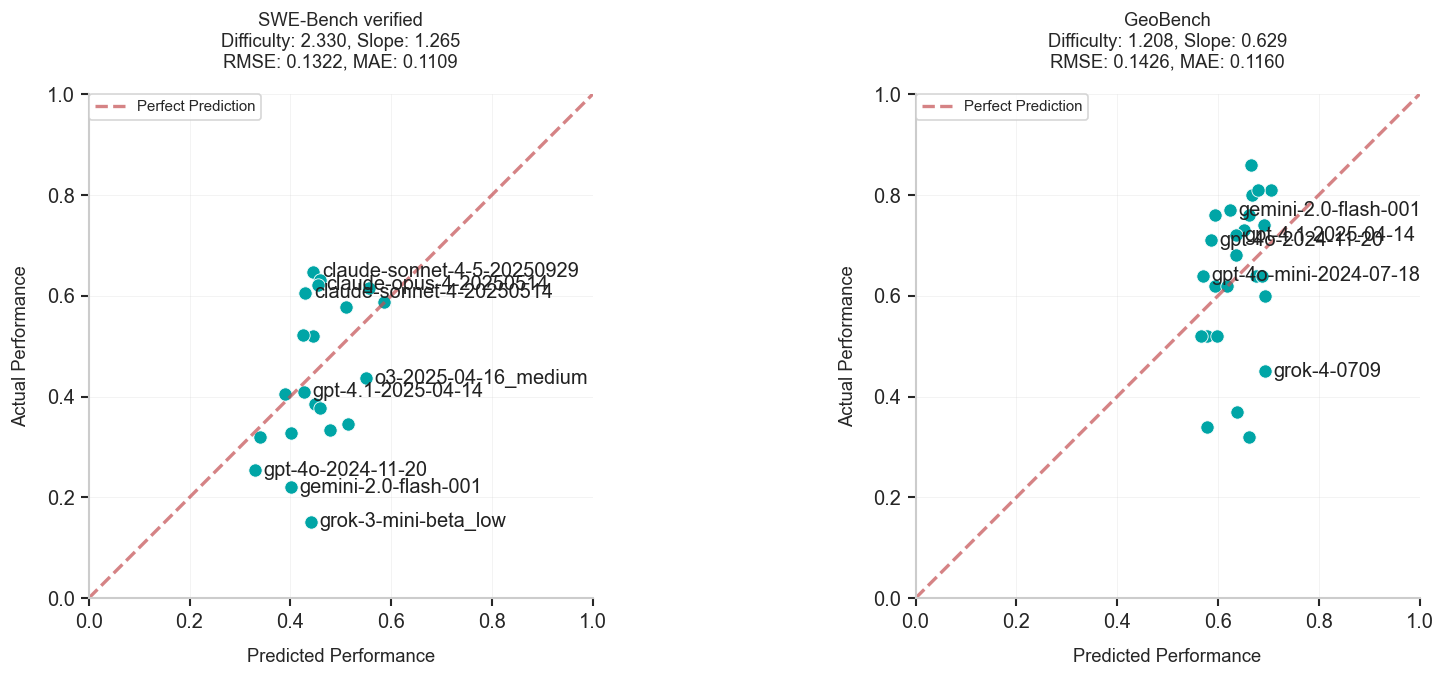


Summary Statistics:

SWE-Bench verified:
  Number of models: 22
  RMSE: 0.1322
  MAE: 0.1109

GeoBench:
  Number of models: 25
  RMSE: 0.1426
  MAE: 0.1160


In [42]:
def plot_two_benchmarks_comparison(benchmark1_name, benchmark2_name, 
                                   df_data=df1, df_capabilities=df_cm1, df_benchmarks=df_db1,
                                   models_to_annotate=None, annotate_all=False,
                                   figsize=(14, 6), save_path=None, annotation_color=None):
    """
    Create a side-by-side comparison of two benchmarks with model annotations.
    
    Parameters:
    -----------
    benchmark1_name : str
        Name of the first benchmark to plot
    benchmark2_name : str
        Name of the second benchmark to plot
    df_data : DataFrame
        DataFrame containing performance data (default: df1)
    df_capabilities : DataFrame
        DataFrame containing model capabilities (default: df_cm1)
    df_benchmarks : DataFrame
        DataFrame containing benchmark parameters (default: df_db1)
    models_to_annotate : list, optional
        List of model names to annotate. If None and annotate_all is False, no annotations.
    annotate_all : bool, default False
        If True, annotate all models (overrides models_to_annotate)
    figsize : tuple, default (14, 6)
        Figure size as (width, height)
    save_path : str, optional
        If provided, save the figure to this path
    annotation_color : str, optional
        Override the annotation text color to keep it visible with custom styles
    """
    
    import matplotlib.colors as mcolors

    def logistic(x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def _resolve_annotation_color(ax):
        if annotation_color is not None:
            return annotation_color
        face_rgb = np.array(mcolors.to_rgb(ax.get_facecolor()))
        luminance = 0.299 * face_rgb[0] + 0.587 * face_rgb[1] + 0.114 * face_rgb[2]
        return '#f5f5f5' if luminance < 0.5 else '#222222'
    
    def prepare_benchmark_data(benchmark_name):
        """Helper function to prepare data for one benchmark"""
        # Get data for this benchmark
        bench_data = df_data[df_data['benchmark'] == benchmark_name].copy()
        
        if len(bench_data) == 0:
            raise ValueError(f"No data found for benchmark: {benchmark_name}")
        
        # Get benchmark parameters
        bench_params_df = df_benchmarks[df_benchmarks['benchmark_name'] == benchmark_name]
        if len(bench_params_df) == 0:
            raise ValueError(f"No parameters found for benchmark: {benchmark_name}")
        
        bench_params = bench_params_df.iloc[0]
        D = bench_params['estimated_difficulty']
        alpha = bench_params['estimated_slope']
        
        # Merge with model capabilities
        bench_data = bench_data.merge(df_capabilities[['model', 'estimated_capability']], 
                                      on='model', how='left')
        
        # Calculate predicted performance
        bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
        
        return bench_data, D, alpha
    
    # Prepare data for both benchmarks
    data1, D1, alpha1 = prepare_benchmark_data(benchmark1_name)
    data2, D2, alpha2 = prepare_benchmark_data(benchmark2_name)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    def plot_single_benchmark(ax, bench_data, benchmark_name, D, alpha):
        """Helper function to plot a single benchmark"""
        # Plot scatter points
        ax.scatter(bench_data['predicted'], bench_data['performance'], 
                  alpha=1, s=64, c=colors[0], edgecolors='white', linewidths=0.5)
        
        # Plot diagonal line (perfect prediction)
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction', alpha=0.7)

        # Ensure consistent axis limits before clipping annotations
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        # Add annotations
        if annotate_all:
            models_to_label = bench_data['model'].tolist()
        elif models_to_annotate is not None:
            models_to_label = [m for m in models_to_annotate if m in bench_data['model'].values]
        else:
            models_to_label = []
        annotations = []
        text_color = _resolve_annotation_color(ax)
        for model in models_to_label:
            model_data = bench_data[bench_data['model'] == model]
            if len(model_data) > 0:
                x = model_data['predicted'].iloc[0]
                y = model_data['performance'].iloc[0]
                annotations.append(ax.annotate(model, xy=(x, y), xytext=(5, 0), 
                           textcoords='offset points', fontsize=12,
                        #    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3),
                           ha='left', va='center', color=text_color))
        
        # hide if they are out of bounds
        if annotations:
            renderer = ax.figure.canvas.get_renderer()
            if renderer is None:
                ax.figure.canvas.draw()
                renderer = ax.figure.canvas.get_renderer()
            x_min, x_max = ax.get_xlim()

            for annotation in annotations:
                # Get bounding box in display coordinates
                bbox = annotation.get_window_extent(renderer=renderer)

                # Convert bbox corners to data coordinates
                (x1, _), (x2, _) = ax.transData.inverted().transform(bbox.get_points())

                # Hide annotation if bbox extends outside the axis x-limits
                if x1 < x_min or x2 > x_max:
                    annotation.set_visible(False)  
        
        # Calculate and display statistics
        residuals = bench_data['performance'] - bench_data['predicted']
        rmse = np.sqrt(np.mean(residuals**2))
        mae = np.mean(np.abs(residuals))
        
        # Set labels and title
        ax.set_xlabel('Predicted Performance', fontsize=11)
        ax.set_ylabel('Actual Performance', fontsize=11)
        ax.set_title(f'{benchmark_name}\nDifficulty: {D:.3f}, Slope: {alpha:.3f}\n' +
                    f'RMSE: {rmse:.4f}, MAE: {mae:.4f}', fontsize=11, pad=10)
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add legend
        ax.legend(loc='upper left', fontsize=9)
        
        # Equal aspect ratio
        ax.set_aspect('equal')
        
        return rmse, mae
    
    # Plot both benchmarks
    rmse1, mae1 = plot_single_benchmark(ax1, data1, benchmark1_name, D1, alpha1)
    rmse2, mae2 = plot_single_benchmark(ax2, data2, benchmark2_name, D2, alpha2)
    
    # Overall title
    fig.suptitle('', 
                fontsize=14, fontweight='bold', y=1.00)
    
    plt.tight_layout()
    
    # Save if path provided
    # if save_path:
    #     plt.savefig(save_path, dpi=300, bbox_inches='tight')
    #     print(f"Figure saved to: {save_path}")
    # plt.savefig('outputs/figures/figure-4.svg', format='svg')
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"\n{benchmark1_name}:")
    print(f"  Number of models: {len(data1)}")
    print(f"  RMSE: {rmse1:.4f}")
    print(f"  MAE: {mae1:.4f}")
    print(f"\n{benchmark2_name}:")
    print(f"  Number of models: {len(data2)}")
    print(f"  RMSE: {rmse2:.4f}")
    print(f"  MAE: {mae2:.4f}")


# Example usage:
# Plot two benchmarks with specific model annotations
models_to_label = ["gpt-4o-2024-11-20", "gemini-2.0-flash-001", "grok-3-mini-beta_low", "claude-sonnet-4-5-20250929", 
                    "claude-sonnet-4-20250514", "claude-opus-4-20250514", "o3-2025-04-16_medium", "grok-4-0709", "gpt-4o-mini-2024-07-18", "gpt-4.1-2025-04-14"]
plot_two_benchmarks_comparison(
    'SWE-Bench verified', 
    'GeoBench',
    models_to_annotate=models_to_label,
    # annotate_all=True,
    save_path='outputs/model_fit/benchmark_comparison_swe_geo.pdf'
)

# Uncomment to annotate all models (warning: can be crowded!)
# plot_two_benchmarks_comparison(
#     'SWE-Bench verified', 
#     'GeoBench',
#     annotate_all=True
# )


In [37]:
set(df_cm1["model"])

{'Baichuan-2-13B-Base',
 'Baichuan-2-7B-Base',
 'Baichuan-7B',
 'Cerebras-GPT-13B',
 'CodeQwen1.5-7B',
 'DeepSeek-Coder-V2-Lite-Base',
 'DeepSeek-R1',
 'DeepSeek-R1-0528',
 'DeepSeek-R1-Distill-Llama-70B',
 'DeepSeek-V2',
 'DeepSeek-V3',
 'DeepSeek-V3-0324',
 'DeepSeek-V3.1',
 'Kimi-K2-Instruct',
 'LLaMA-13B',
 'LLaMA-33B',
 'LLaMA-65B',
 'LLaMA-7B',
 'Llama-2-13b',
 'Llama-2-34b',
 'Llama-2-70b-hf ',
 'Llama-2-7b',
 'Llama-3.1-405B',
 'Llama-3.1-405B-Instruct',
 'Llama-3.1-70B-Instruct',
 'Llama-3.1-8B-Instruct',
 'Llama-3.2-90B-Vision-Instruct',
 'Llama-3.3-70B-Instruct',
 'Llama-4-Maverick-17B-128E-Instruct',
 'Llama-4-Maverick-17B-128E-Instruct-FP8',
 'Llama-4-Scout-17B-16E-Instruct',
 'Meta-Llama-3-70B-Instruct',
 'Meta-Llama-3-8B-Instruct',
 'Mistral-7B-v0.1',
 'Mixtral-8x7B-v0.1',
 'Nemotron-4 15B',
 'PaLM 2-L',
 'PaLM 2-M',
 'PaLM 2-S',
 'Phi-3-medium-128k-instruct',
 'Phi-3-mini-4k-instruct',
 'Phi-3-small-8k-instruct',
 'Qwen-14B',
 'Qwen-1_8B',
 'Qwen-7B',
 'Qwen2.5-72B',
 '

In [38]:
set(scores_df["model"])

{'Baichuan-2-13B-Base',
 'Baichuan-2-7B-Base',
 'Baichuan-7B',
 'Cerebras-GPT-13B',
 'CodeQwen1.5-7B',
 'DeepSeek-Coder-V2-Lite-Base',
 'DeepSeek-R1',
 'DeepSeek-R1-0528',
 'DeepSeek-R1-Distill-Llama-70B',
 'DeepSeek-V2',
 'DeepSeek-V3',
 'DeepSeek-V3-0324',
 'DeepSeek-V3.1',
 'Kimi-K2-Instruct',
 'LLaMA-13B',
 'LLaMA-33B',
 'LLaMA-65B',
 'LLaMA-7B',
 'Llama-2-13b',
 'Llama-2-34b',
 'Llama-2-70b-hf ',
 'Llama-2-7b',
 'Llama-3.1-405B',
 'Llama-3.1-405B-Instruct',
 'Llama-3.1-70B-Instruct',
 'Llama-3.1-8B-Instruct',
 'Llama-3.2-90B-Vision-Instruct',
 'Llama-3.3-70B-Instruct',
 'Llama-4-Maverick-17B-128E-Instruct',
 'Llama-4-Maverick-17B-128E-Instruct-FP8',
 'Llama-4-Scout-17B-16E-Instruct',
 'Meta-Llama-3-70B-Instruct',
 'Meta-Llama-3-8B-Instruct',
 'Mistral-7B-v0.1',
 'Mixtral-8x7B-v0.1',
 'Nemotron-4 15B',
 'PaLM 2-L',
 'PaLM 2-M',
 'PaLM 2-S',
 'Phi-3-medium-128k-instruct',
 'Phi-3-mini-4k-instruct',
 'Phi-3-small-8k-instruct',
 'Qwen-14B',
 'Qwen-1_8B',
 'Qwen-7B',
 'Qwen2.5-72B',
 '

In [14]:
scores_df[scores_df['benchmark'] == "SWE-Bench verified"]

,model_id,benchmark_id,performance,benchmark,benchmark_release_date,optimized,is_math,is_coding,model,date,source
10,m10,b6,0.606,SWE-Bench verified,2024-08-13,True,False,True,claude-haiku-4-5-20251001,2025-10-15,Epoch evaluations
56,m103,b6,0.437,SWE-Bench verified,2024-08-13,True,False,True,o3-2025-04-16_medium,2025-04-16,Epoch evaluations
67,m104,b6,0.346,SWE-Bench verified,2024-08-13,True,False,True,o4-mini-2025-04-16_medium,2025-04-16,Epoch evaluations
93,m109,b6,0.521,SWE-Bench verified,2024-08-13,True,False,True,DeepSeek-V3.1,2025-08-21,Epoch evaluations
180,m12,b6,0.648,SWE-Bench verified,2024-08-13,True,False,True,claude-sonnet-4-5-20250929,2025-09-29,Epoch evaluations
243,m13,b6,0.578,SWE-Bench verified,2024-08-13,True,False,True,gpt-5-mini-2025-08-07_medium,2025-08-07,Epoch evaluations
336,m14,b6,0.588,SWE-Bench verified,2024-08-13,True,False,True,gpt-5-2025-08-07_medium,2025-08-07,Epoch evaluations
569,m18,b6,0.632,SWE-Bench verified,2024-08-13,True,False,True,claude-opus-4-1-20250805,2025-08-05,Epoch evaluations
645,m22,b6,0.333,SWE-Bench verified,2024-08-13,True,False,True,DeepSeek-R1-0528,2025-05-28,Epoch evaluations
679,m26,b6,0.386,SWE-Bench verified,2024-08-13,True,False,True,grok-3-beta,2025-04-09,Epoch evaluations


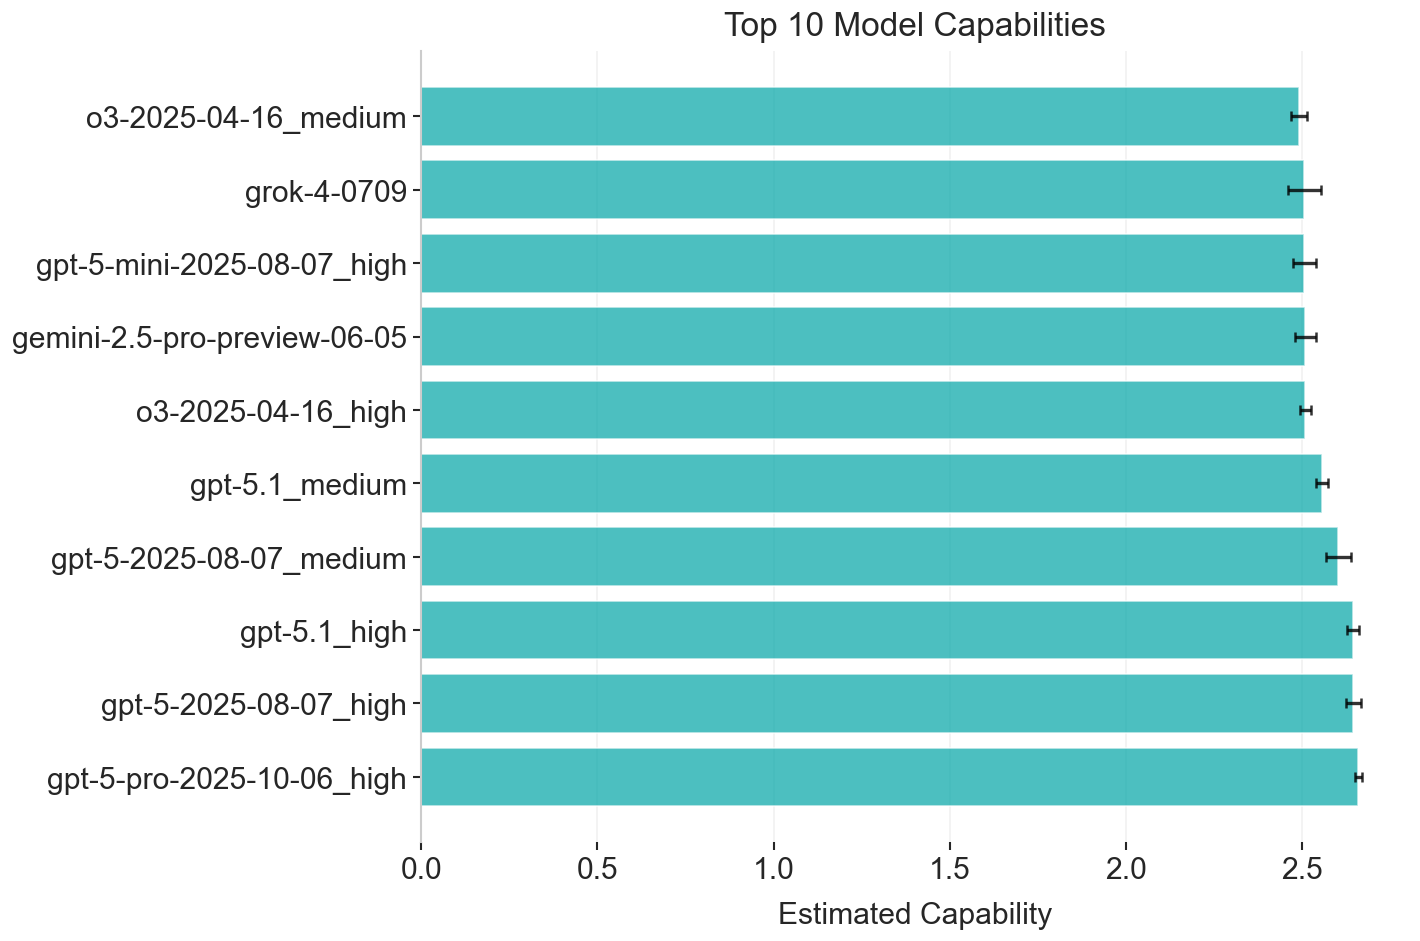


Top 10 Models by Capability:
 1. gpt-5-pro-2025-10-06_high                     2.6587 (±0.0096, +0.0103)
 2. gpt-5-2025-08-07_high                         2.6448 (±0.0212, +0.0218)
 3. gpt-5.1_high                                  2.6442 (±0.0173, +0.0177)
 4. gpt-5-2025-08-07_medium                       2.6025 (±0.0342, +0.0353)
 5. gpt-5.1_medium                                2.5564 (±0.0163, +0.0171)
 6. o3-2025-04-16_high                            2.5091 (±0.0165, +0.0169)
 7. gemini-2.5-pro-preview-06-05                  2.5084 (±0.0300, +0.0304)
 8. gpt-5-mini-2025-08-07_high                    2.5059 (±0.0314, +0.0324)
 9. grok-4-0709                                   2.5050 (±0.0453, +0.0471)
10. o3-2025-04-16_medium                          2.4905 (±0.0229, +0.0233)


In [15]:
# Model Capabilities Ranking - Top 20 Models
fig, ax = plt.subplots(figsize=(12, 8))

# Get data with valid capabilities
df_capabilities_clean = df_cm1.dropna(subset=['date', 'estimated_capability'])
top_models = df_capabilities_clean.nlargest(10, 'estimated_capability')

# Merge with error bars
top_models_with_errors = top_models.merge(
    capability_errors[['model', 'error_minus', 'error_plus']], 
    on='model', 
    how='left'
)

y_pos = np.arange(len(top_models_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_models_with_errors['estimated_capability'], alpha=0.7)
ax.errorbar(top_models_with_errors['estimated_capability'], y_pos,
            xerr=[top_models_with_errors['error_minus'], top_models_with_errors['error_plus']],
            fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_models_with_errors['model'], fontsize=18)
ax.tick_params(axis='x', labelsize=18)

ax.grid(False, axis='y')
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Estimated Capability', fontsize=18)
ax.set_title('Top 10 Model Capabilities', fontsize=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig("outputs/model_fit/model_capabilities_ranking.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("outputs/figures/figure-2a.svg", format="svg")

plt.show()

print("\nTop 10 Models by Capability:")
for i, (idx, row) in enumerate(top_models_with_errors.iterrows()):
    print(f"{i+1:2d}. {row['model']:45s} {row['estimated_capability']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})")


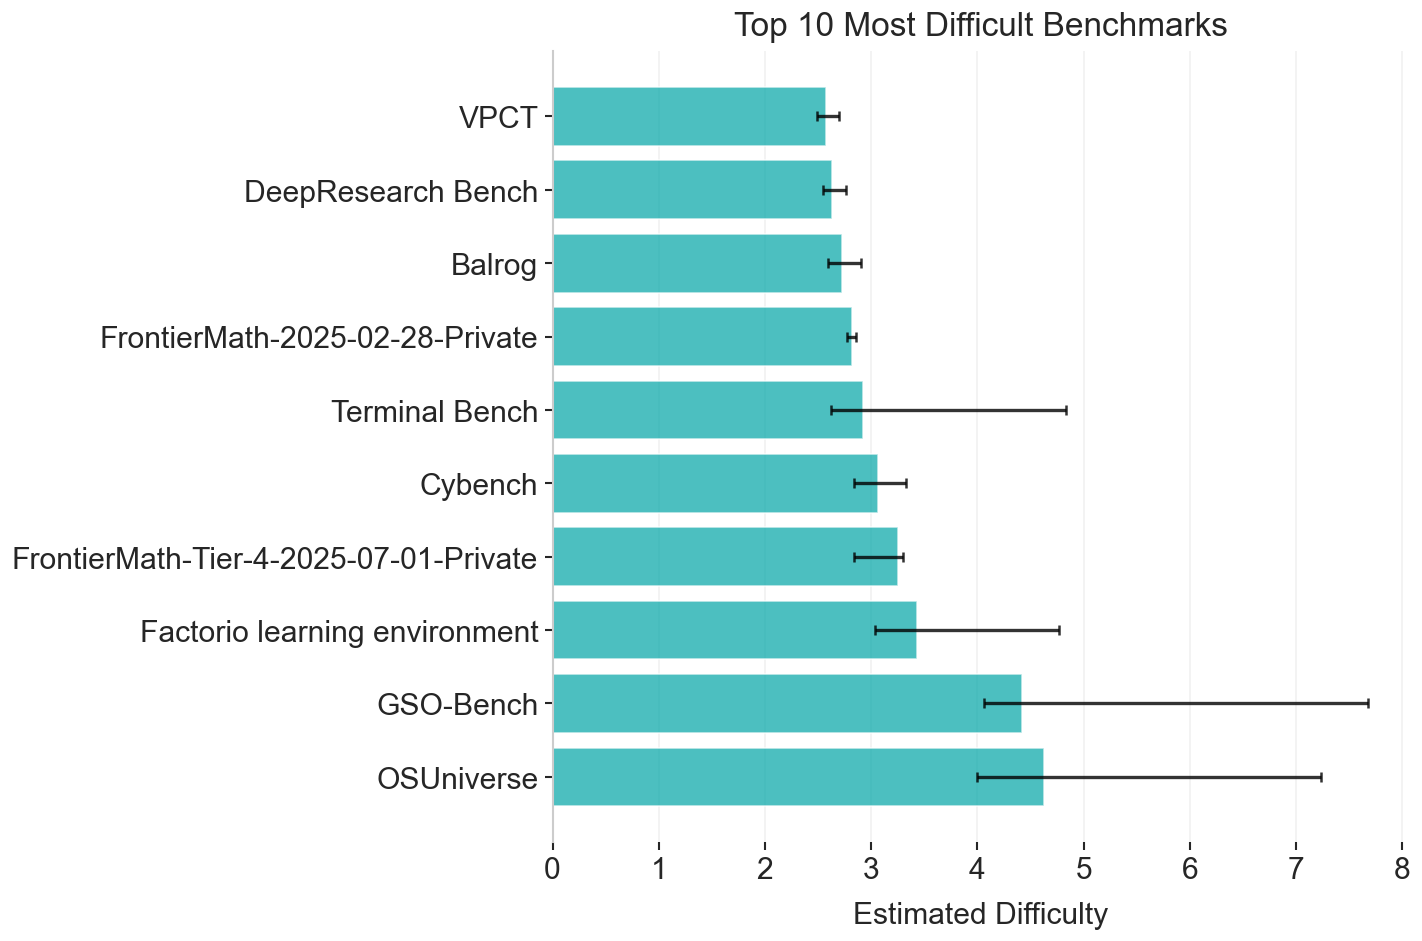


Top 10 Most Difficult Benchmarks:
 1. OSUniverse                                    4.6244 (±0.6293, +2.6050)
 2. GSO-Bench                                     4.4216 (±0.3569, +3.2552)
 3. Factorio learning environment                 3.4352 (±0.3969, +1.3338)
 4. FrontierMath-Tier-4-2025-07-01-Private        3.2518 (±0.4174, +0.0428)
 5. Cybench                                       3.0664 (±0.2241, +0.2571)
 6. Terminal Bench                                2.9216 (±0.3007, +1.9075)
 7. FrontierMath-2025-02-28-Private               2.8236 (±0.0491, +0.0333)
 8. Balrog                                        2.7222 (±0.1284, +0.1779)
 9. DeepResearch Bench                            2.6265 (±0.0758, +0.1404)
10. VPCT                                          2.5715 (±0.0806, +0.1224)


In [16]:
# Benchmark Difficulties Ranking - Top 15 Most Difficult Benchmarks
fig, ax = plt.subplots(figsize=(12, 8))

# Sort benchmarks by difficulty and get top 15
df_benchmarks_sorted = df_db1.sort_values('estimated_difficulty', ascending=True)
top_difficult = df_benchmarks_sorted.nlargest(10, 'estimated_difficulty')

# Merge with error bars
top_difficult_with_errors = top_difficult.merge(
    difficulty_errors[['benchmark_name', 'error_minus', 'error_plus']], 
    on='benchmark_name', 
    how='left'
)

y_pos = np.arange(len(top_difficult_with_errors))

# Create horizontal bar chart with error bars
ax.barh(y_pos, top_difficult_with_errors['estimated_difficulty'], alpha=0.7)
ax.errorbar(top_difficult_with_errors['estimated_difficulty'], y_pos,
            xerr=[top_difficult_with_errors['error_minus'], top_difficult_with_errors['error_plus']],
            fmt='none', ecolor='black', capsize=3, capthick=1.5, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(top_difficult_with_errors['benchmark_name'], fontsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_xlabel('Estimated Difficulty', fontsize=18)
ax.set_title('Top 10 Most Difficult Benchmarks', fontsize=20)
ax.grid(True, alpha=0.3, axis='x')
ax.grid(False, axis='y')
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig("outputs/model_fit/benchmark_difficulties_ranking.pdf", dpi=300, bbox_inches='tight')
# plt.savefig("outputs/figures/figure-2b.svg", format="svg")

plt.show()

print("\nTop 10 Most Difficult Benchmarks:")
for i, (idx, row) in enumerate(top_difficult_with_errors.iterrows()):
    print(f"{i+1:2d}. {row['benchmark_name']:45s} {row['estimated_difficulty']:.4f} (±{row['error_minus']:.4f}, +{row['error_plus']:.4f})")


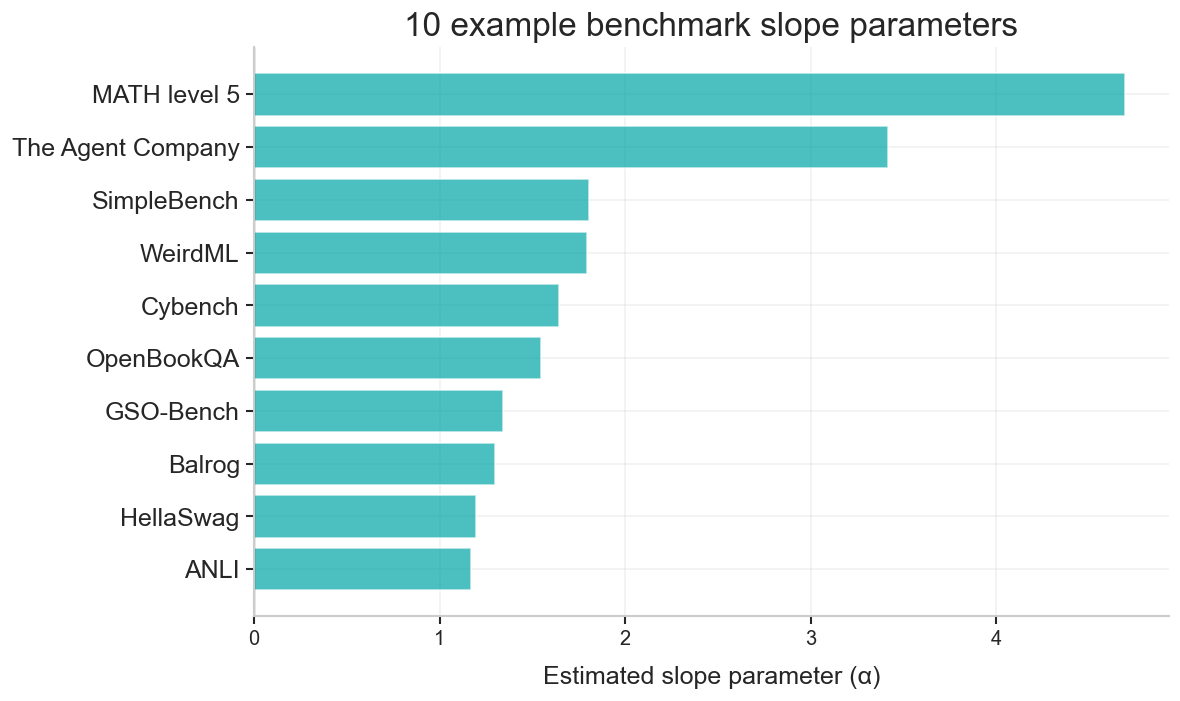


10 Example benchmark slope parameters
 1. ANLI                                          1.1694
 2. HellaSwag                                     1.1984
 3. Balrog                                        1.2989
 4. GSO-Bench                                     1.3403
 5. OpenBookQA                                    1.5471
 6. Cybench                                       1.6444
 7. WeirdML                                       1.7933
 8. SimpleBench                                   1.8035
 9. The Agent Company                             3.4136
10. MATH level 5                                  4.6939


In [17]:
# Example Benchmark Slopes - Choose specific benchmarks or N random ones
import numpy as np

# Configuration
benchmark_names = None  # Set to list of benchmark names, e.g., ['MMLU', 'GPQA diamond', 'ARC AI2'], or None for random
N_random = 10  # Number of random benchmarks to select (only used if benchmark_names is None)

# Select benchmarks
if benchmark_names is not None:
    selected_df = df_db1[df_db1['benchmark_name'].isin(benchmark_names)]
else:
    selected_df = df_db1.sample(n=min(N_random, len(df_db1)), random_state=42)

# Sort by slope for better visualization
selected_df = selected_df.sort_values('estimated_slope', ascending=True)

# Create bar chart
fig, ax = plt.subplots(figsize=(10, max(6, len(selected_df) * 0.4)))
y_pos = np.arange(len(selected_df))

ax.barh(y_pos, selected_df['estimated_slope'], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(selected_df['benchmark_name'], fontsize=15)
ax.set_xlabel('Estimated slope parameter (α)', fontsize=15)
ax.set_title(f'{len(selected_df)} example benchmark slope parameters', fontsize=20)
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.savefig("outputs/model_fit/example_benchmark_slope_parameters.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Print values
print(f"\n{len(selected_df)} Example benchmark slope parameters")
for i, (idx, row) in enumerate(selected_df.iterrows()):
    print(f"{i+1:2d}. {row['benchmark_name']:45s} {row['estimated_slope']:.4f}")

# Does it predict how models do on some more interpretable metrics? 

In [18]:
df_metr = pd.read_csv("data/external_benchmark_metr.csv")
columns = {
    "Model version": "model",
    "Time horizon": "time_horizon",
}
df_metr.rename(columns=columns, inplace=True)
df_metr

,id,model,CI_high,CI_low,time_horizon,Source,Source link,average_score,Notes
0,rec3I5CcPGjF3Riat,claude-3-5-sonnet-20240620,34.472569,9.492954,18.216830,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.476797,NaN
1,recM2JJhzA3vJAZoZ,claude-3-5-sonnet-20241022,56.988170,13.345031,28.983512,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.527010,NaN
2,recqRojHxRU5ySXWq,claude-3-7-sonnet-20250219_16K,89.828760,27.763038,54.226342,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.599681,NaN
3,recyvUC4eTQ5SK6Gr,claude-3-opus-20240229,12.951308,2.743525,6.422825,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.377459,NaN
4,recuz9bui4PgiPuGH,claude-opus-4-1-20250805_16K,192.232318,53.816764,105.499169,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.668069,NaN
5,recjchvjch6vUVmzs,claude-opus-4-20250514_16K,136.369866,42.377009,79.862937,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.639292,NaN
6,recwCLGT9Kr3iDcqu,claude-sonnet-4-5-20250929_16K,235.506801,52.719920,113.303764,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.673842,NaN
7,recueBmSBs2QlEWPm,claude-sonnet-4-20250514_16K,118.627631,34.401631,67.705892,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.619725,NaN
8,recbmHH5GLQL9jfZn,davinci-002,0.251337,0.070646,0.148860,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.161869,NaN
9,rectWm0PAizmHcDik,DeepSeek-R1,50.977460,13.478936,26.932599,METR - Measuring AI Ability to Complete Long T...,https://metr.org/blog/2025-03-19-measuring-ai-...,0.519251,NaN


Original df_metr rows: 30
Original df_cm1 rows: 178
Combined df rows (models in both): 23

Models in combined dataset:
                             model  time_horizon  estimated_capability
0       claude-3-5-sonnet-20240620     18.216830              1.808271
1       claude-3-5-sonnet-20241022     28.983512              1.972531
2   claude-3-7-sonnet-20250219_16K     54.226342              2.171659
3           claude-3-opus-20240229      6.422825              1.672169
4     claude-opus-4-1-20250805_16K    105.499169              2.256643
5       claude-opus-4-20250514_16K     79.862937              2.263551
6     claude-sonnet-4-20250514_16K     67.705892              2.251755
7                      DeepSeek-R1     26.932599              2.177720
8                 DeepSeek-R1-0528     31.167847              2.261185
9                      DeepSeek-V3     18.472532              1.927445
10                DeepSeek-V3-0324     23.117113              2.088105
11    gemini-2.5-pro-preview-

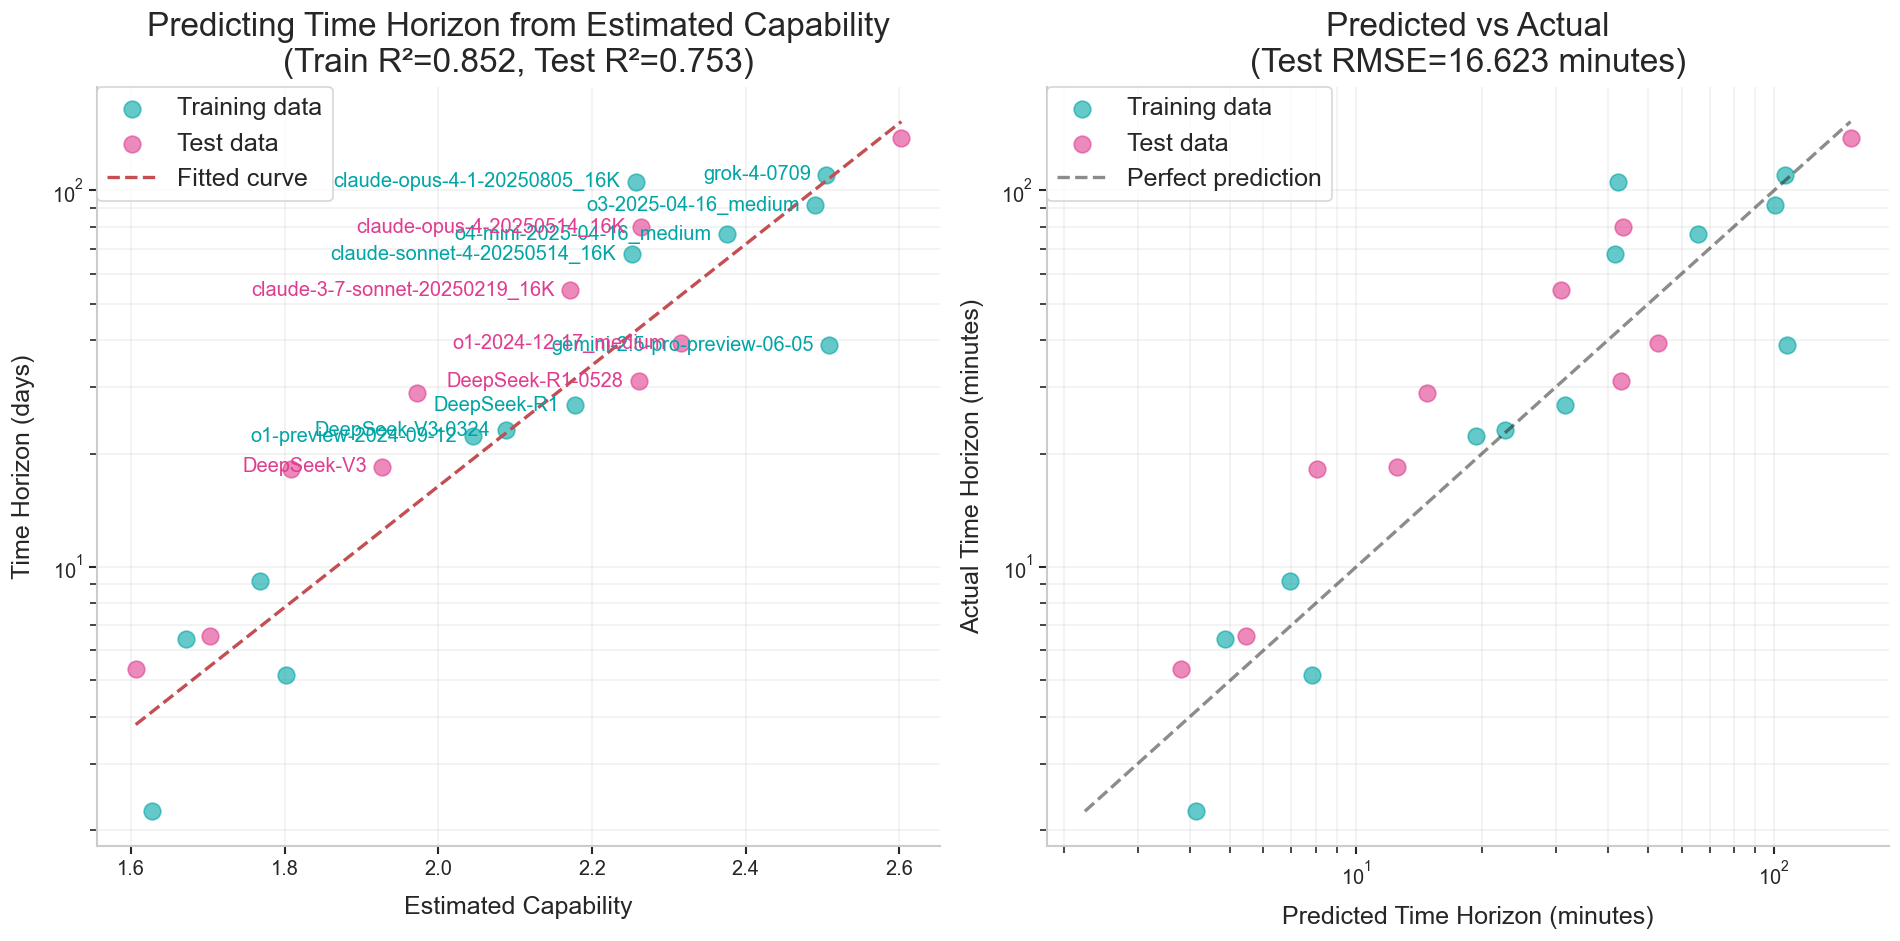


TEST SET PREDICTIONS (Original Scale)
                         model  estimated_capability  time_horizon  predicted_time_horizon      error  abs_error  pct_error
    claude-opus-4-20250514_16K              2.263551     79.862937               43.409552  36.453385  36.453385  45.644934
claude-3-7-sonnet-20250219_16K              2.171659     54.226342               30.893133  23.333209  23.333209  43.029288
       gpt-5-2025-08-07_medium              2.602451    137.318539              152.194323 -14.875784  14.875784 -10.833048
    claude-3-5-sonnet-20241022              1.972531     28.983512               14.782434  14.201078  14.201078  48.997091
          o1-2024-12-17_medium              2.316271     39.206576               52.764105 -13.557529  13.557529 -34.579733
              DeepSeek-R1-0528              2.261185     31.167847               43.031184 -11.863337  11.863337 -38.062741
    claude-3-5-sonnet-20240620              1.808271     18.216830                8.047899  1

In [19]:
# Combine df_metr and df_cm1 to predict time_horizon from estimated_capability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Merge the two dataframes on model
df_combined = df_metr.merge(
    df_cm1[['model', 'estimated_capability']], 
    on='model', 
    how='inner'
)

print(f"Original df_metr rows: {len(df_metr)}")
print(f"Original df_cm1 rows: {len(df_cm1)}")
print(f"Combined df rows (models in both): {len(df_combined)}")
print(f"\nModels in combined dataset:")
print(df_combined[['model', 'time_horizon', 'estimated_capability']])

# Check for missing values
print(f"\nMissing values:")
print(df_combined[['model', 'time_horizon', 'estimated_capability']].isnull().sum())

# Remove any rows with missing values and non-positive time_horizon values
df_combined_clean = df_combined.dropna(subset=['time_horizon', 'estimated_capability'])
df_combined_clean = df_combined_clean[df_combined_clean['time_horizon'] > 0].copy()
print(f"\nRows after removing missing values and non-positive time_horizon: {len(df_combined_clean)}")

# Add log-transformed time_horizon
df_combined_clean['log_time_horizon'] = np.log(df_combined_clean['time_horizon'])
print(f"\nTime horizon statistics:")
print(f"  Original - Min: {df_combined_clean['time_horizon'].min():.2f}, Max: {df_combined_clean['time_horizon'].max():.2f}, Mean: {df_combined_clean['time_horizon'].mean():.2f}")
print(f"  Log-transformed - Min: {df_combined_clean['log_time_horizon'].min():.2f}, Max: {df_combined_clean['log_time_horizon'].max():.2f}, Mean: {df_combined_clean['log_time_horizon'].mean():.2f}")

if len(df_combined_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
    print("Consider using leave-one-out cross-validation or all data for fitting.")
else:
    # Train-test split (80/20)
    X = df_combined_clean[['estimated_capability']].values
    y = df_combined_clean['log_time_horizon'].values  # Use log-transformed target
    y_original = df_combined_clean['time_horizon'].values  # Keep original for reference
    
    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_combined_clean.index, test_size=0.4, random_state=42
    )
    
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics on training set
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Metrics on test set
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)
    
    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)
    
    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    
    print(f"\n" + "="*60)
    print("MODEL PERFORMANCE (Random Split)")
    print("="*60)
    print(f"\nModel equation: log(time_horizon) = {model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f}")
    print(f"Or equivalently: time_horizon = exp({model.coef_[0]:.4f} * estimated_capability + {model.intercept_:.4f})")
    
    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")
    
    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")
    
    # print(f"\nTraining Set (original scale after back-transform):")
    # print(f"  R²: {train_r2_original:.4f}")
    # print(f"  RMSE: {train_rmse_original:.4f}")
    
    # print(f"\nTest Set (original scale after back-transform):")
    # print(f"  R²: {test_r2_original:.4f}")
    # print(f"  RMSE: {test_rmse_original:.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Scatter plot with fit line (with log scale on y-axis)
    ax1 = axes[0]
    # Plot original time_horizon values (not log-transformed)
    ax1.scatter(X_train, y_train_original, alpha=0.6, s=100, label='Training data', color=colors[0])
    ax1.scatter(X_test, y_test_original, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # Plot regression line (back-transformed to original scale)
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model.predict(X_range)
    y_range_pred_original = np.exp(y_range_pred)
    ax1.plot(X_range, y_range_pred_original, 'r--', linewidth=2, label='Fitted curve')
    
    # Annotate points with model names
    annotations = []
    for idx in idx_train:
        annotations.append(
            ax1.annotate(df_combined_clean.loc[idx, 'model'], 
                        xy=(df_combined_clean.loc[idx, 'estimated_capability'] - 0.02, 
                            df_combined_clean.loc[idx, 'time_horizon']),
                        fontsize=12, alpha=1, ha='right', color=colors[0], va='center')
        )
    
    for idx in idx_test:
        annotations.append(
        ax1.annotate(df_combined_clean.loc[idx, 'model'], 
                    xy=(df_combined_clean.loc[idx, 'estimated_capability'] - 0.02, 
                        df_combined_clean.loc[idx, 'time_horizon']),
                    fontsize=12, alpha=1, ha='right', color=colors[1], va='center')
        )

    


    # hide if they are out of bounds
    x_min, x_max = X.min(), X.max()

    for annotation in annotations:
        # Get bounding box in display coordinates
        bbox = annotation.get_window_extent(renderer=ax1.figure.canvas.get_renderer())

        # Convert bbox corners to data coordinates
        (x1, _), (x2, _) = ax1.transData.inverted().transform(bbox.get_points())

        # Hide annotation if bbox extends outside the axis x-limits
        if x1 < x_min or x2 > x_max:
            annotation.set_visible(False)  

    
    
    ax1.set_xlabel('Estimated Capability', fontsize=15)
    ax1.set_ylabel('Time Horizon (days)', fontsize=15)
    ax1.set_yscale('log')  # Set y-axis to logarithmic scale
    ax1.set_title(f'Predicting Time Horizon from Estimated Capability\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})', 
                 fontsize=20)
    ax1.legend(fontsize=15)
    ax1.grid(True, alpha=0.3, which='both')  # Show grid for both major and minor ticks
    
    # Plot 2: Predicted vs Actual (with log scale on both axes)
    ax2 = axes[1]
    ax2.scatter(y_train_pred_original, y_train_original, alpha=0.6, s=100, label='Training data', color=colors[0])
    ax2.scatter(y_test_pred_original, y_test_original, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # Plot diagonal line (perfect predictions)
    y_min_orig = min(y_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
    y_max_orig = max(y_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
    ax2.plot([y_min_orig, y_max_orig], [y_min_orig, y_max_orig], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    ax2.set_xlabel('Predicted Time Horizon (minutes)', fontsize=15)
    ax2.set_ylabel('Actual Time Horizon (minutes)', fontsize=15)
    ax2.set_xscale('log')  # Set x-axis to logarithmic scale
    ax2.set_yscale('log')  # Set y-axis to logarithmic scale
    ax2.set_title(f'Predicted vs Actual\n(Test RMSE={test_rmse_original:.3f} minutes)', fontsize=20)
    ax2.legend(fontsize=15)
    ax2.grid(True, alpha=0.3, which='both')  # Show grid for both major and minor ticks
    
    plt.tight_layout()
    plt.savefig("outputs/model_fit/predicting_time_horizon_from_capability.pdf", dpi=300, bbox_inches='tight')
    # plt.savefig("outputs/figures/figure-3.svg", format="svg")

    plt.show()
    
    # Print test set predictions vs actuals
    print(f"\n" + "="*60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("="*60)
    test_results = df_combined_clean.loc[idx_test, ['model', 'estimated_capability', 'time_horizon']].copy()
    test_results['predicted_time_horizon'] = y_test_pred_original
    test_results['error'] = y_test_original - y_test_pred_original
    test_results['abs_error'] = np.abs(test_results['error'])
    test_results['pct_error'] = 100 * test_results['error'] / y_test_original
    test_results = test_results.sort_values('abs_error', ascending=False)
    
    print(test_results.to_string(index=False))


In [20]:
# ============================================================================
# BENCHMARK-BASED ANALYSIS: Predict time_horizon from benchmark performance
# ============================================================================
# TO ANALYZE A DIFFERENT BENCHMARK: Simply change BENCHMARK_NAME below!
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# ============================================================================
# BENCHMARK CONFIGURATION - Change this to analyze different benchmarks!
# ============================================================================
# Examples: "GPQA diamond", "MMLU", "BBH", "HellaSwag", "MATH level 5", 
#           "FrontierMath-2025-02-28-Private", "ARC AI2", etc.
# To see all available: print(sorted(df1['benchmark'].unique()))

BENCHMARK_NAME = 'GPQA diamond'  # ← CHANGE THIS to analyze different benchmarks

# ============================================================================

# Filter for specified benchmark
df_benchmark = df1[df1['benchmark'] == BENCHMARK_NAME].copy()
print(f"'{BENCHMARK_NAME}' benchmark has {len(df_benchmark)} model evaluations")

if len(df_benchmark) == 0:
    print(f"\n⚠️ ERROR: No data found for benchmark '{BENCHMARK_NAME}'")
    print("\nAvailable benchmarks:")
    for bench in sorted(df1['benchmark'].unique()):
        print(f"  - {bench}")

# Apply inverse sigmoid (logit) transformation to performance
# logit(p) = log(p / (1-p))
# Clip performance to avoid log(0) or log(inf)
epsilon = 1e-6
df_benchmark['performance_clipped'] = df_benchmark['performance'].clip(epsilon, 1 - epsilon)
df_benchmark['logit_performance'] = np.log(df_benchmark['performance_clipped'] / (1 - df_benchmark['performance_clipped']))

print(f"\n{BENCHMARK_NAME} Performance statistics:")
print(f"  Original - Min: {df_benchmark['performance'].min():.4f}, Max: {df_benchmark['performance'].max():.4f}, Mean: {df_benchmark['performance'].mean():.4f}")
print(f"  Logit-transformed - Min: {df_benchmark['logit_performance'].min():.4f}, Max: {df_benchmark['logit_performance'].max():.4f}, Mean: {df_benchmark['logit_performance'].mean():.4f}")

# Merge with METR time_horizon data
df_benchmark_metr = df_benchmark.merge(
    df_metr[['model', 'time_horizon']], 
    on='model', 
    how='inner'
)

# Also merge with model dates for temporal split
df_benchmark_metr = df_benchmark_metr.merge(
    df_cm1[['model', 'date', 'date_obj']],
    on='model',
    how='inner'
)

print(f"\nModels with both {BENCHMARK_NAME} performance and METR time_horizon: {len(df_benchmark_metr)}")
print(f"\nModels in combined {BENCHMARK_NAME}-METR dataset:")
print(df_benchmark_metr[['model', 'performance', 'logit_performance', 'time_horizon']].to_string(index=False))


'GPQA diamond' benchmark has 101 model evaluations

GPQA diamond Performance statistics:
  Original - Min: 0.1470, Max: 0.8760, Mean: 0.5904
  Logit-transformed - Min: -1.7583, Max: 1.9551, Mean: 0.4160

Models with both GPQA diamond performance and METR time_horizon: 21

Models in combined GPQA diamond-METR dataset:
                         model  performance  logit_performance  time_horizon
          o1-2024-12-17_medium        0.758           1.141746     39.206576
                   DeepSeek-V3        0.565           0.261480     18.472532
                   grok-4-0709        0.870           1.900959    110.075251
       gpt-5-2025-08-07_medium        0.854           1.766325    137.318539
  claude-opus-4-1-20250805_16K        0.773           1.225329    105.499169
  gemini-2.5-pro-preview-06-05        0.848           1.719000     38.734274
              DeepSeek-R1-0528        0.763           1.169198     31.167847
                   DeepSeek-R1        0.717           0.929629   


Rows after removing missing values and non-positive time_horizon: 21

Train set size: 12
Test set size: 9

GPQA DIAMOND RANDOM SPLIT MODEL PERFORMANCE

Model equation: log(time_horizon) = 1.5609 * logit(GPQA diamond_perf) + 2.0866
Or equivalently: time_horizon = exp(1.5609 * logit(GPQA diamond_perf) + 2.0866)

Training Set (log scale):
  R²: 0.8418
  RMSE: 0.4718
  MAE: 0.3834
  Pearson r: 0.9175 (p=0.0000)

Test Set (log scale):
  R²: 0.6485
  RMSE: 0.5928
  MAE: 0.4794
  Pearson r: 0.8943 (p=0.0011)


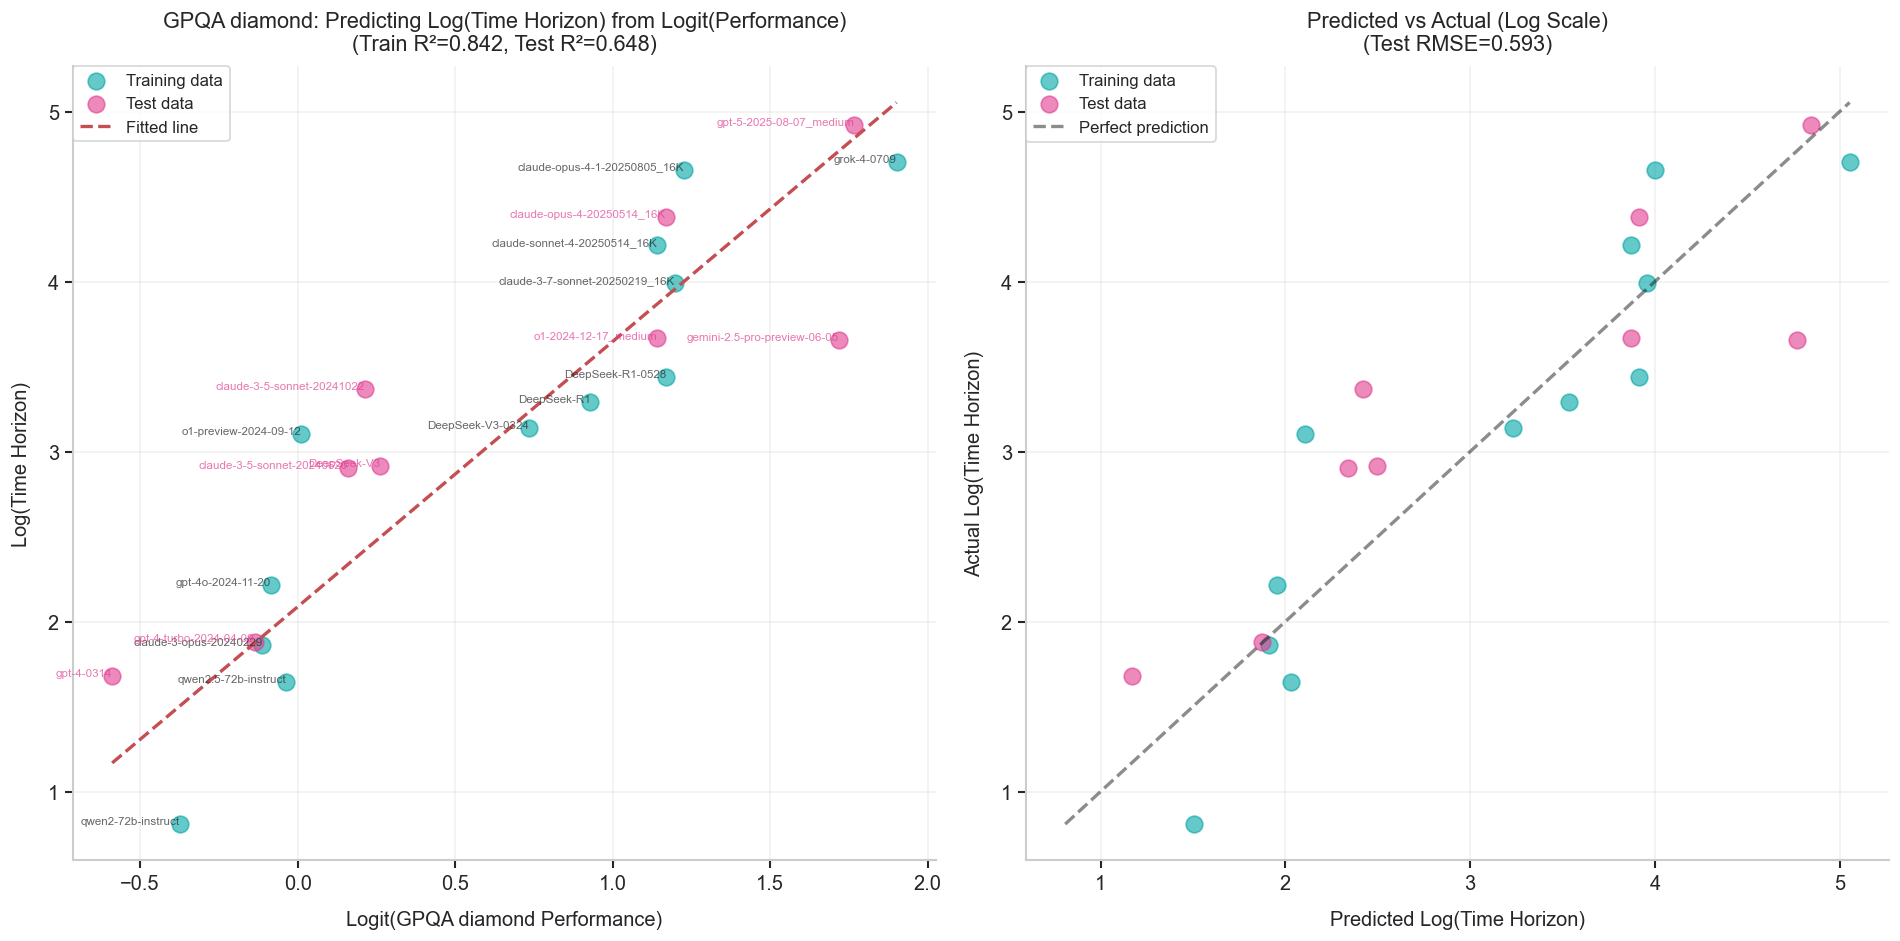


TEST SET PREDICTIONS (Original Scale)
                       model  performance  logit_performance  time_horizon  predicted_time_horizon      error  abs_error   pct_error
gemini-2.5-pro-preview-06-05        0.848           1.719000     38.734274              117.890913 -79.156639  79.156639 -204.358132
  claude-opus-4-20250514_16K        0.763           1.169198     79.862937               49.977988  29.884949  29.884949   37.420298
  claude-3-5-sonnet-20241022        0.553           0.212799     28.983512               11.231882  17.751630  17.751630   61.247339
     gpt-5-2025-08-07_medium        0.854           1.766325    137.318539              126.928975  10.389564  10.389564    7.566032
        o1-2024-12-17_medium        0.758           1.141746     39.206576               47.881679  -8.675103   8.675103  -22.126653
  claude-3-5-sonnet-20240620        0.540           0.160343     18.216830               10.348871   7.867959   7.867959   43.190602
                 DeepSeek-V3  

In [21]:
# BENCHMARK RANDOM SPLIT: Predict log(time_horizon) from logit(benchmark performance)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Remove rows with missing values and non-positive time_horizon values
df_benchmark_clean = df_benchmark_metr.dropna(subset=['time_horizon', 'logit_performance'])
df_benchmark_clean = df_benchmark_clean[df_benchmark_clean['time_horizon'] > 0].copy()
print(f"\nRows after removing missing values and non-positive time_horizon: {len(df_benchmark_clean)}")

# Add log-transformed time_horizon
df_benchmark_clean['log_time_horizon'] = np.log(df_benchmark_clean['time_horizon'])

if len(df_benchmark_clean) < 5:
    print("\n⚠️ WARNING: Too few data points for meaningful train-test split analysis!")
else:
    # Train-test split (80/20)
    X = df_benchmark_clean[['logit_performance']].values
    y = df_benchmark_clean['log_time_horizon'].values  # Use log-transformed target
    y_original = df_benchmark_clean['time_horizon'].values  # Keep original for reference
    
    # Random state for reproducibility
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, df_benchmark_clean.index, test_size=0.4, random_state=42
    )
    
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # Fit linear regression model
    model_gpqa = LinearRegression()
    model_gpqa.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model_gpqa.predict(X_train)
    y_test_pred = model_gpqa.predict(X_test)
    
    # Metrics on log scale
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Pearson correlation
    train_corr, train_corr_pval = stats.pearsonr(y_train, y_train_pred)
    test_corr, test_corr_pval = stats.pearsonr(y_test, y_test_pred)
    
    # Calculate metrics on original scale as well
    y_train_original = y_original[idx_train]
    y_test_original = y_original[idx_test]
    y_train_pred_original = np.exp(y_train_pred)
    y_test_pred_original = np.exp(y_test_pred)
    
    train_r2_original = r2_score(y_train_original, y_train_pred_original)
    test_r2_original = r2_score(y_test_original, y_test_pred_original)
    train_rmse_original = np.sqrt(mean_squared_error(y_train_original, y_train_pred_original))
    test_rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    
    print(f"\n" + "="*60)
    print(f"{BENCHMARK_NAME.upper()} RANDOM SPLIT MODEL PERFORMANCE")
    print("="*60)
    print(f"\nModel equation: log(time_horizon) = {model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f}")
    print(f"Or equivalently: time_horizon = exp({model_gpqa.coef_[0]:.4f} * logit({BENCHMARK_NAME}_perf) + {model_gpqa.intercept_:.4f})")
    
    print(f"\nTraining Set (log scale):")
    print(f"  R²: {train_r2:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE: {train_mae:.4f}")
    print(f"  Pearson r: {train_corr:.4f} (p={train_corr_pval:.4f})")
    
    print(f"\nTest Set (log scale):")
    print(f"  R²: {test_r2:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  MAE: {test_mae:.4f}")
    print(f"  Pearson r: {test_corr:.4f} (p={test_corr_pval:.4f})")
    
    # print(f"\nTraining Set (original scale after back-transform):")
    # print(f"  R²: {train_r2_original:.4f}")
    # print(f"  RMSE: {train_rmse_original:.4f}")
    
    # print(f"\nTest Set (original scale after back-transform):")
    # print(f"  R²: {test_r2_original:.4f}")
    # print(f"  RMSE: {test_rmse_original:.4f}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: Scatter plot with fit line (LOG SCALE)
    ax1 = axes[0]
    ax1.scatter(X_train, y_train, alpha=0.6, s=100, label='Training data', color=colors[0])
    ax1.scatter(X_test, y_test, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # Plot regression line
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_range_pred = model_gpqa.predict(X_range)
    ax1.plot(X_range, y_range_pred, 'r--', linewidth=2, label='Fitted line')
    
    # Annotate points with model names
    for idx in idx_train:
        ax1.annotate(df_benchmark_clean.loc[idx, 'model'], 
                    xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
                        df_benchmark_clean.loc[idx, 'log_time_horizon']),
                    fontsize=7, alpha=0.7, ha='right')
    
    for idx in idx_test:
        ax1.annotate(df_benchmark_clean.loc[idx, 'model'], 
                    xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
                        df_benchmark_clean.loc[idx, 'log_time_horizon']),
                    fontsize=7, alpha=0.7, ha='right', color=colors[1])
    
    ax1.set_xlabel(f'Logit({BENCHMARK_NAME} Performance)', fontsize=12)
    ax1.set_ylabel('Log(Time Horizon)', fontsize=12)
    ax1.set_title(f'{BENCHMARK_NAME}: Predicting Log(Time Horizon) from Logit(Performance)\n(Train R²={train_r2:.3f}, Test R²={test_r2:.3f})', 
                 fontsize=13)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Predicted vs Actual (LOG SCALE)
    ax2 = axes[1]
    ax2.scatter(y_train_pred, y_train, alpha=0.6, s=100, label='Training data', color=colors[0])
    ax2.scatter(y_test_pred, y_test, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # Plot diagonal line (perfect predictions)
    y_min = min(y.min(), y_train_pred.min(), y_test_pred.min())
    y_max = max(y.max(), y_train_pred.max(), y_test_pred.max())
    ax2.plot([y_min, y_max], [y_min, y_max], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    ax2.set_xlabel('Predicted Log(Time Horizon)', fontsize=12)
    ax2.set_ylabel('Actual Log(Time Horizon)', fontsize=12)
    ax2.set_title(f'Predicted vs Actual (Log Scale)\n(Test RMSE={test_rmse:.3f})', fontsize=13)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # # Plot 3: Scatter plot with fit line (ORIGINAL SCALE)
    # ax3 = axes[1, 0]
    # ax3.scatter(X_train, y_train_original, alpha=0.6, s=100, label='Training data', color=colors[0])
    # ax3.scatter(X_test, y_test_original, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # # Plot regression line (back-transformed)
    # y_range_pred_original = np.exp(y_range_pred)
    # ax3.plot(X_range, y_range_pred_original, 'r--', linewidth=2, label='Fitted curve')
    
    # # Annotate points with model names
    # for idx in idx_train:
    #     ax3.annotate(df_benchmark_clean.loc[idx, 'model'], 
    #                 xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
    #                     df_benchmark_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right')
    
    # for idx in idx_test:
    #     ax3.annotate(df_benchmark_clean.loc[idx, 'model'], 
    #                 xy=(df_benchmark_clean.loc[idx, 'logit_performance'], 
    #                     df_benchmark_clean.loc[idx, 'time_horizon']),
    #                 fontsize=7, alpha=0.7, ha='right', color=colors[1])
    
    # ax3.set_xlabel(f'Logit({BENCHMARK_NAME} Performance)', fontsize=12)
    # ax3.set_ylabel('Time Horizon (Original Scale)', fontsize=12)
    # ax3.set_title(f'{BENCHMARK_NAME}: Predicting Time Horizon (Original Scale)\n(Train R²={train_r2_original:.3f}, Test R²={test_r2_original:.3f})', 
    #              fontsize=13)
    # ax3.legend()
    # ax3.grid(True, alpha=0.3)
    
    # # Plot 4: Predicted vs Actual (ORIGINAL SCALE)
    # ax4 = axes[1, 1]
    # ax4.scatter(y_train_pred_original, y_train_original, alpha=0.6, s=100, label='Training data', color=colors[0])
    # ax4.scatter(y_test_pred_original, y_test_original, alpha=0.6, s=100, label='Test data', color=colors[1])
    
    # # Plot diagonal line (perfect predictions)
    # y_min_orig = min(y_original.min(), y_train_pred_original.min(), y_test_pred_original.min())
    # y_max_orig = max(y_original.max(), y_train_pred_original.max(), y_test_pred_original.max())
    # ax4.plot([y_min_orig, y_max_orig], [y_min_orig, y_max_orig], 'k--', linewidth=2, alpha=0.5, label='Perfect prediction')
    
    # ax4.set_xlabel('Predicted Time Horizon', fontsize=12)
    # ax4.set_ylabel('Actual Time Horizon', fontsize=12)
    # ax4.set_title(f'Predicted vs Actual (Original Scale)\n(Test RMSE={test_rmse_original:.3f})', fontsize=13)
    # ax4.legend()
    # ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("outputs/notebooks/predicting_time_horizon_from_benchmark_performance.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print test set predictions vs actuals
    print(f"\n" + "="*60)
    print("TEST SET PREDICTIONS (Original Scale)")
    print("="*60)
    test_results = df_benchmark_clean.loc[idx_test, ['model', 'performance', 'logit_performance', 'time_horizon']].copy()
    test_results['predicted_time_horizon'] = y_test_pred_original
    test_results['error'] = y_test_original - y_test_pred_original
    test_results['abs_error'] = np.abs(test_results['error'])
    test_results['pct_error'] = 100 * test_results['error'] / y_test_original
    test_results = test_results.sort_values('abs_error', ascending=False)
    
    print(test_results.to_string(index=False))


# Other checks

Line of best fit slope: 0.7170 capability units/year
R-squared: 0.7741


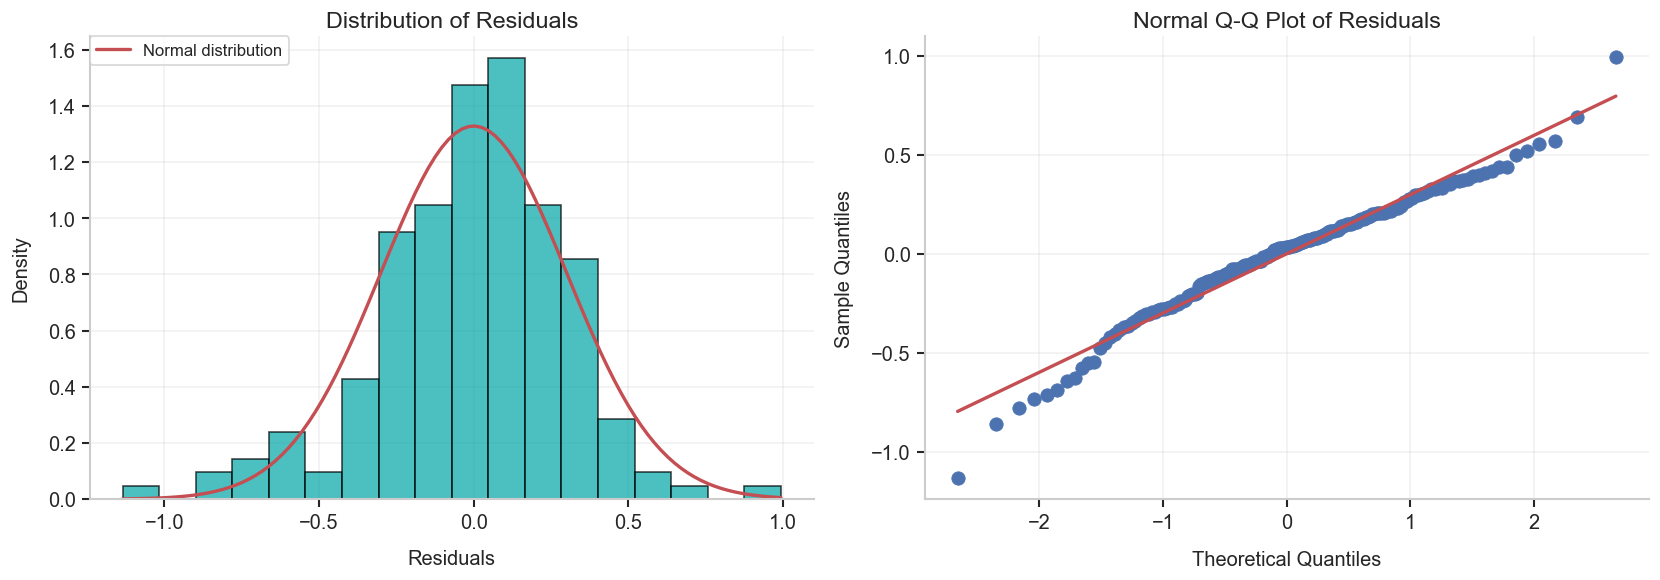


NORMALITY TESTS FOR RESIDUALS

Basic Statistics:
  Mean: 0.000000
  Standard Deviation: 0.3011
  Skewness: -0.5165
  Kurtosis: 1.3523
  Min: -1.1344
  Max: 0.9924
  Sample size: 178

Kolmogorov-Smirnov Test:
  Test statistic: 0.0711
  P-value: 0.3142
  Interpretation: FAIL TO REJECT null hypothesis of normality (α=0.05)

Shapiro-Wilk Test:
  Test statistic: 0.9746
  P-value: 0.0025
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Anderson-Darling Test:
  Test statistic: 1.2282
  Critical values: [0.564 0.642 0.77  0.899 1.069]
  Significance levels: [15.  10.   5.   2.5  1. ]%
  Interpretation: REJECT null hypothesis of normality (α=0.05)

Jarque-Bera Test:
  Test statistic: 21.4765
  P-value: 0.0000
  Interpretation: REJECT null hypothesis of normality (α=0.05)

SUMMARY FOR SYNTHETIC DATA GENERATION

Normality test summary: 3/4 tests reject normality
Recommendation: ✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions

Additional cons

In [25]:
# Residuals analysis with normality testing for synthetic data generation
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import scipy.stats as stats

# Prepare data for residuals analysis
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df = cap_df.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Convert dates to numerical format for regression
X = (cap_df['date_obj'] - cap_df['date_obj'].min()).dt.days.values.reshape(-1, 1)
y = cap_df['estimated_capability'].values

# Fit linear regression (line of best fit)
lr = LinearRegression()
lr.fit(X, y)

# Calculate predicted values and residuals
y_pred = lr.predict(X)
residuals = y - y_pred

# Convert slope to per-year rate
slope_per_year = lr.coef_[0] * 365.25
r2 = lr.score(X, y)

print(f"Line of best fit slope: {slope_per_year:.4f} capability units/year")
print(f"R-squared: {r2:.4f}")

# Create residuals analysis plot (distribution and Q-Q plot only)
fig = plt.figure(figsize=(14, 5))

# 1. Histogram of residuals with normal overlay
ax1 = plt.subplot(1, 2, 1)
n_bins = int(np.sqrt(len(residuals))) + 5  # Sturges' rule with buffer
counts, bins, patches = ax1.hist(residuals, bins=n_bins, density=True, alpha=0.7, edgecolor='black')

# Overlay normal distribution
x_norm = np.linspace(residuals.min(), residuals.max(), 100)
normal_overlay = stats.norm.pdf(x_norm, np.mean(residuals), np.std(residuals))
ax1.plot(x_norm, normal_overlay, 'r-', linewidth=2, label='Normal distribution')
ax1.set_xlabel('Residuals', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Residuals', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Q-Q plot
ax2 = plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=ax2)

# set line color

ax2.set_xlabel('Theoretical Quantiles', fontsize=12)
ax2.set_ylabel('Sample Quantiles', fontsize=12)
ax2.set_title('Normal Q-Q Plot of Residuals', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/model_fit/model_capabilities_residuals_normality_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Statistical tests for normality
print(f"\n" + "="*60)
print("NORMALITY TESTS FOR RESIDUALS")
print("="*60)

# Basic statistics
print(f"\nBasic Statistics:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Standard Deviation: {np.std(residuals, ddof=1):.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")
print(f"  Min: {np.min(residuals):.4f}")
print(f"  Max: {np.max(residuals):.4f}")
print(f"  Sample size: {len(residuals)}")

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Test statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if ks_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Shapiro-Wilk test (more powerful for small to moderate sample sizes)
if len(residuals) <= 5000:  # Shapiro-Wilk works best for n <= 5000
    sw_stat, sw_pvalue = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk Test:")
    print(f"  Test statistic: {sw_stat:.4f}")
    print(f"  P-value: {sw_pvalue:.4f}")
    print(f"  Interpretation: {'REJECT' if sw_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Anderson-Darling test
ad_stat, ad_critical_vals, ad_significance_levels = stats.anderson(residuals, dist='norm')
print(f"\nAnderson-Darling Test:")
print(f"  Test statistic: {ad_stat:.4f}")
print(f"  Critical values: {ad_critical_vals}")
print(f"  Significance levels: {ad_significance_levels}%")
# Find the appropriate critical value for 5% significance
ad_5pct_critical = ad_critical_vals[np.where(ad_significance_levels == 5)[0][0]] if 5 in ad_significance_levels else ad_critical_vals[2]
print(f"  Interpretation: {'REJECT' if ad_stat > ad_5pct_critical else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

# Jarque-Bera test
jb_stat, jb_pvalue = stats.jarque_bera(residuals)
print(f"\nJarque-Bera Test:")
print(f"  Test statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_pvalue:.4f}")
print(f"  Interpretation: {'REJECT' if jb_pvalue < 0.05 else 'FAIL TO REJECT'} null hypothesis of normality (α=0.05)")

print(f"\n" + "="*60)
print("SUMMARY FOR SYNTHETIC DATA GENERATION")
print("="*60)

# Count how many tests reject normality
tests_results = [
    ("Kolmogorov-Smirnov", ks_pvalue < 0.05),
    ("Jarque-Bera", jb_pvalue < 0.05),
    ("Anderson-Darling", ad_stat > ad_5pct_critical)
]

if len(residuals) <= 5000:
    tests_results.append(("Shapiro-Wilk", sw_pvalue < 0.05))

rejections = sum([result[1] for result in tests_results])
total_tests = len(tests_results)

print(f"\nNormality test summary: {rejections}/{total_tests} tests reject normality")
if rejections == 0:
    recommendation = "✓ GAUSSIAN NOISE assumption appears REASONABLE for synthetic data"
elif rejections <= total_tests // 2:
    recommendation = "⚠ GAUSSIAN NOISE assumption is QUESTIONABLE - consider checking sample size or alternative distributions"
else:
    recommendation = "✗ GAUSSIAN NOISE assumption is NOT SUPPORTED - consider alternative noise distributions"

print(f"Recommendation: {recommendation}")

# Additional diagnostics
print(f"\nAdditional considerations:")
if abs(stats.skew(residuals)) > 0.5:
    print(f"  • Residuals show notable skewness ({stats.skew(residuals):.3f})")
if abs(stats.kurtosis(residuals)) > 1.0:
    print(f"  • Residuals show notable kurtosis ({stats.kurtosis(residuals):.3f})")
if len(residuals) < 30:
    print(f"  • Small sample size (n={len(residuals)}) - normality tests have limited power")

print(f"\nFor synthetic data generation:")
print(f"  • Estimated noise std: {np.std(residuals, ddof=1):.4f}")
print(f"  • Suggested distribution: {'Normal(0, {:.4f})'.format(np.std(residuals, ddof=1)) if rejections == 0 else 'Consider empirical distribution or robust alternatives'}")

# Show models with extreme residuals
print(f"\nModels with largest absolute residuals (potential outliers):")
abs_residuals_idx = np.argsort(np.abs(residuals))[-5:]
for idx in abs_residuals_idx[::-1]:
    model_name = cap_df.iloc[idx]['model']
    residual_val = residuals[idx]
    print(f"  {model_name}: {residual_val:.4f}")

Testing different loss increase thresholds...

Threshold: 1.0%

Threshold: 2.5%

Threshold: 5.0%

Threshold: 10.0%

Threshold: 15.0%


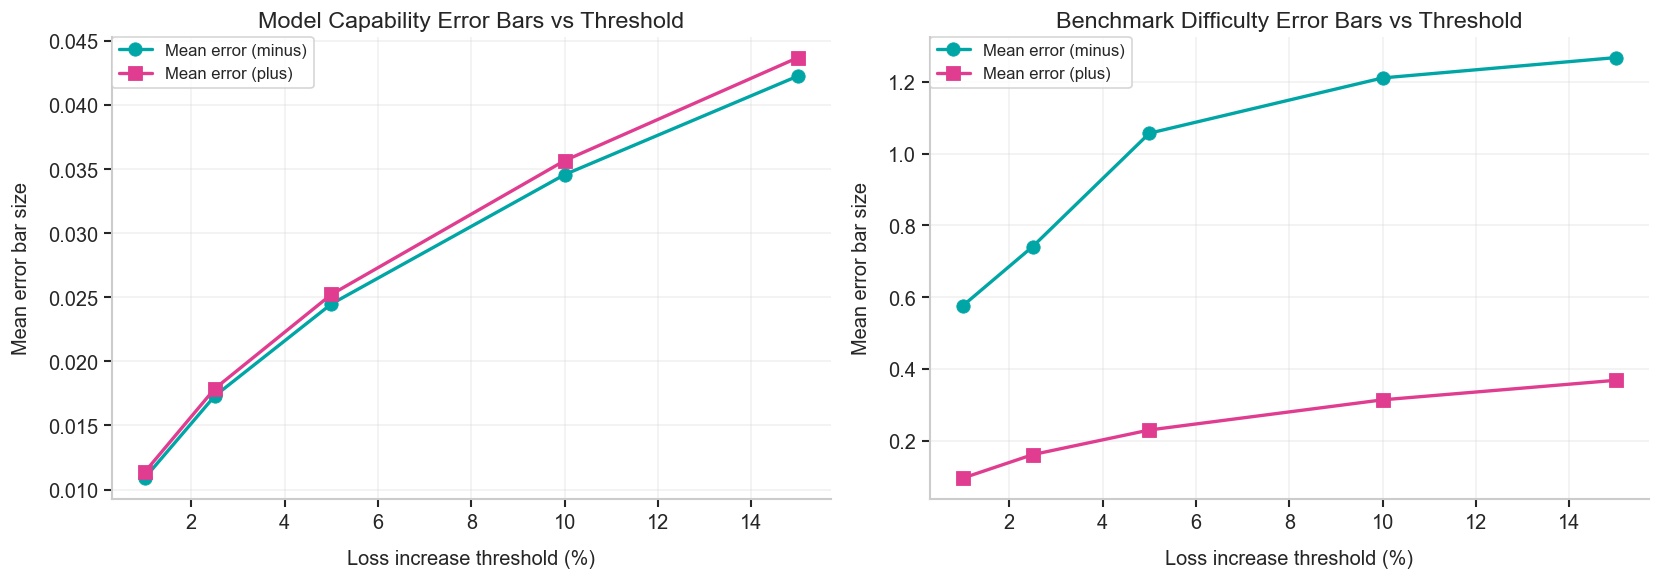


THRESHOLD SENSITIVITY ANALYSIS

As the threshold increases, error bars get larger (we allow more deviation)
The 5% threshold (0.05) is a reasonable default, but you can adjust it based on
how conservative you want your uncertainty estimates to be.


In [22]:
# ── SENSITIVITY ANALYSIS: Different Threshold Values ──────────────────────

# Test different thresholds
thresholds = [0.01, 0.025, 0.05, 0.10, 0.15]
threshold_results_cap = []
threshold_results_bench = []

print("Testing different loss increase thresholds...")
for threshold in thresholds:
    print(f"\nThreshold: {threshold*100}%")
    
    # Compute error bars with this threshold (only for a subset to save time)
    # Let's just compute for a few models and benchmarks to demonstrate
    cap_errors_sample = compute_capability_error_bars(
        df1, df_cm1.head(10), df_db1, loss_increase_threshold=threshold
    )
    
    bench_errors_sample = compute_difficulty_error_bars(
        df1, df_cm1, df_db1.head(10), loss_increase_threshold=threshold
    )
    
    threshold_results_cap.append({
        'threshold': threshold,
        'mean_error_minus': cap_errors_sample['error_minus'].mean(),
        'mean_error_plus': cap_errors_sample['error_plus'].mean()
    })
    
    threshold_results_bench.append({
        'threshold': threshold,
        'mean_error_minus': bench_errors_sample['error_minus'].mean(),
        'mean_error_plus': bench_errors_sample['error_plus'].mean()
    })

# Plot how error bars change with threshold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Capabilities
df_thresh_cap = pd.DataFrame(threshold_results_cap)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax1.plot(df_thresh_cap['threshold'] * 100, df_thresh_cap['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax1.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax1.set_ylabel('Mean error bar size', fontsize=12)
ax1.set_title('Model Capability Error Bars vs Threshold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Benchmarks
df_thresh_bench = pd.DataFrame(threshold_results_bench)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_minus'], 
         'o-', label='Mean error (minus)', linewidth=2, markersize=8)
ax2.plot(df_thresh_bench['threshold'] * 100, df_thresh_bench['mean_error_plus'], 
         's-', label='Mean error (plus)', linewidth=2, markersize=8)
ax2.set_xlabel('Loss increase threshold (%)', fontsize=12)
ax2.set_ylabel('Mean error bar size', fontsize=12)
ax2.set_title('Benchmark Difficulty Error Bars vs Threshold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/notebooks/threshold_sensitivity_analysis.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)
print("\nAs the threshold increases, error bars get larger (we allow more deviation)")
print("The 5% threshold (0.05) is a reasonable default, but you can adjust it based on")
print("how conservative you want your uncertainty estimates to be.")


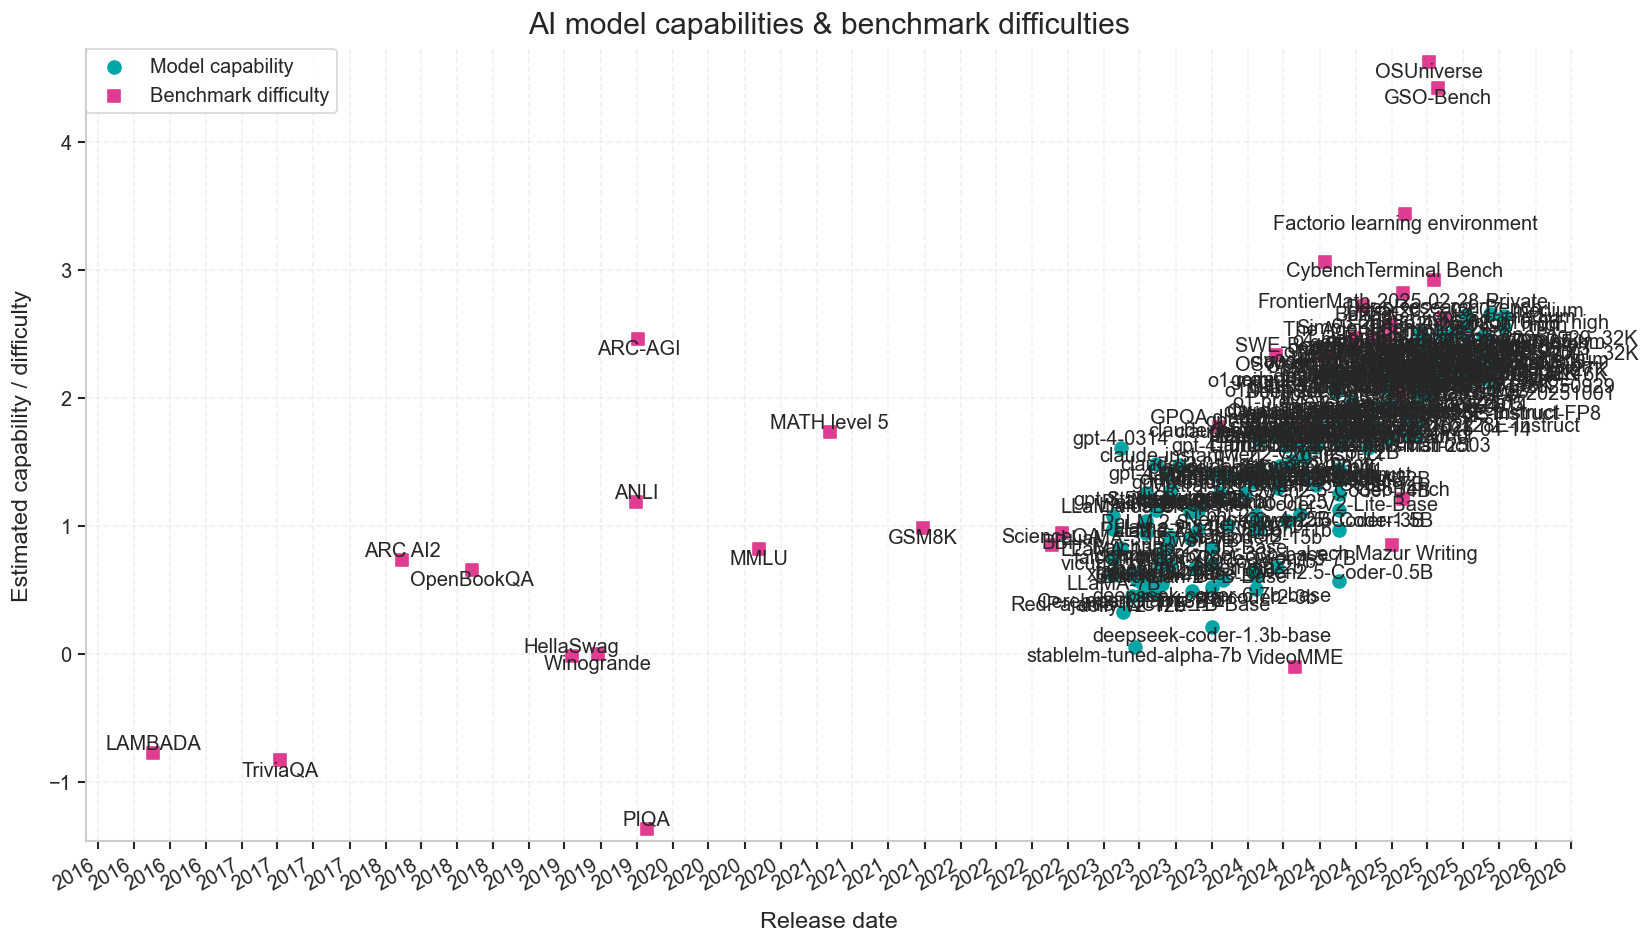

In [23]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color=colors[0],  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color=colors[1], label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    # if name not in annotate_models:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    # if name not in annotate_benchmarks:
    #     continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/notebooks/capabilities_and_benchmarks_over_time_all_annotated.pdf", dpi=300, bbox_inches='tight')
plt.show()


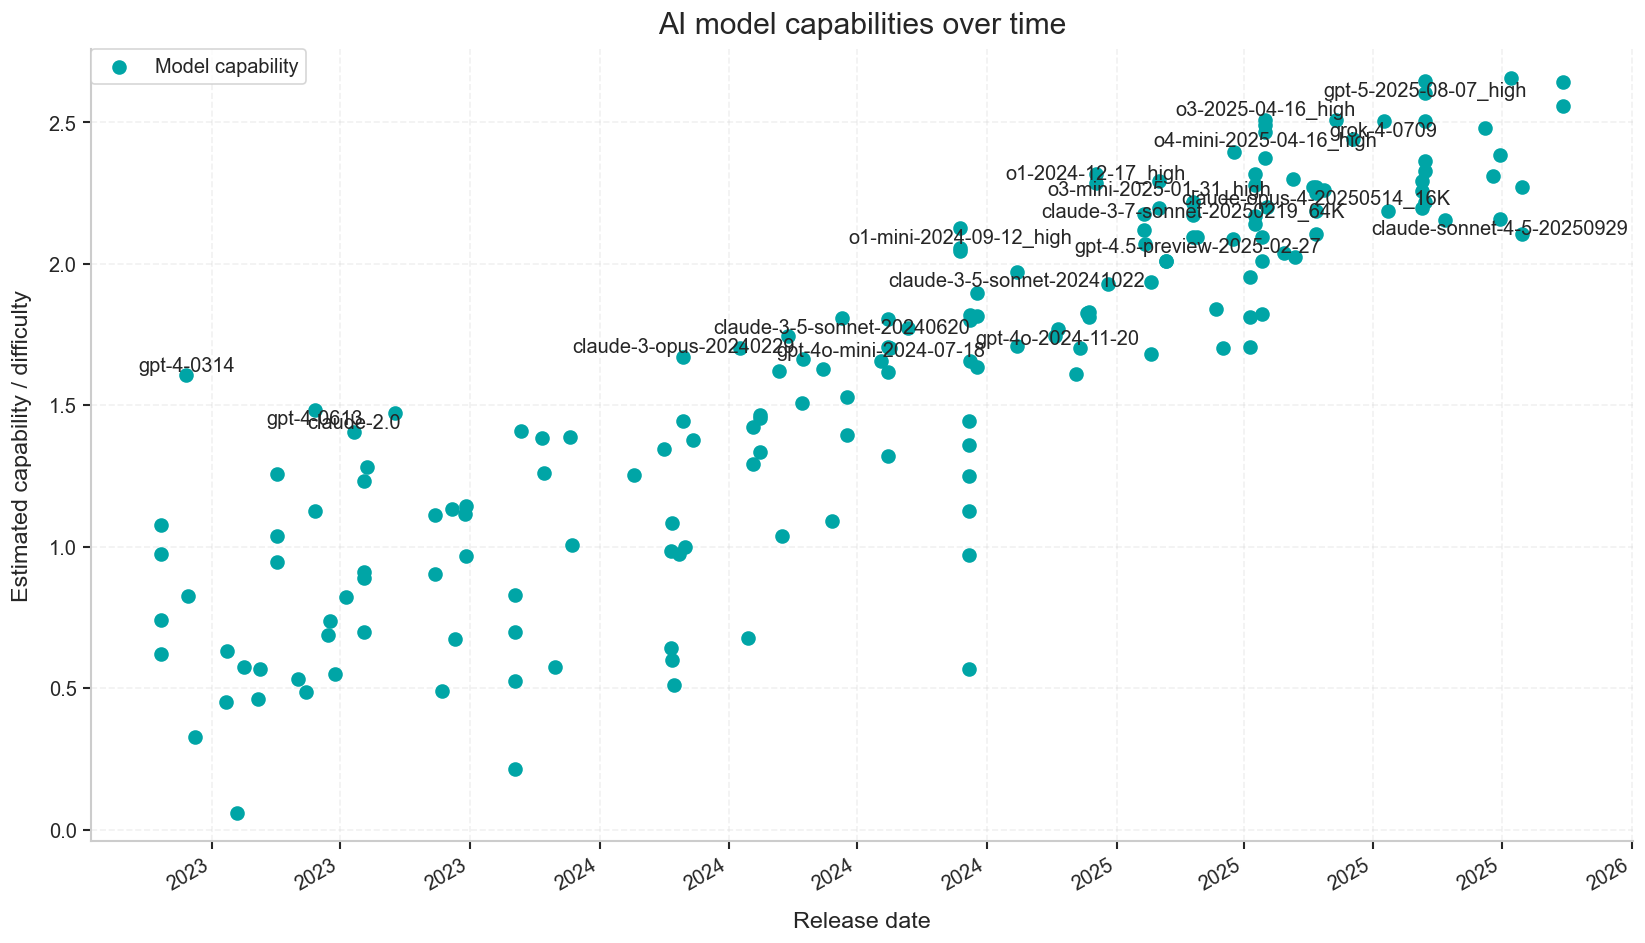

In [24]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color=colors[0],  label='Model capability')
# bench_plot = ax.scatter(bench_dates_num, bench_values,
#                         marker='s', s=60, color=colors[1], label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in ref_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities over time", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = cap_values.min() - 0.1
max_y = cap_values.max() + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("outputs/notebooks/capabilities_over_time.pdf", dpi=300, bbox_inches='tight')
plt.show()


Bootstrapped mean rate: 0.7173 capability units/year
95% confidence interval: [0.6596, 0.7762]


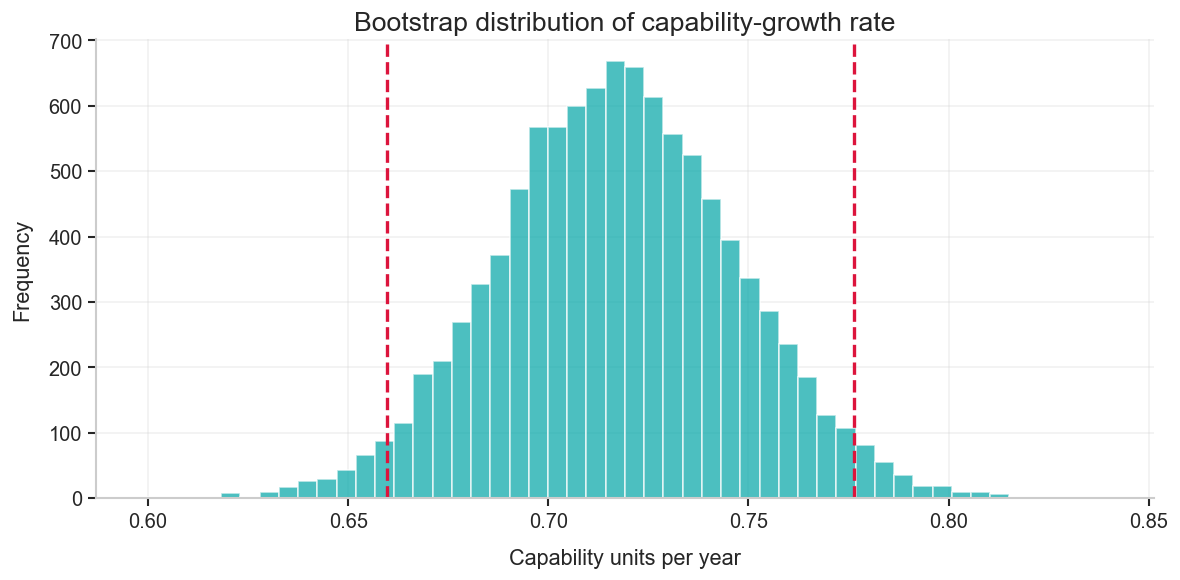

In [25]:
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
# y_full = cap_values.to_numpy()         # capability values (float64)

mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]
y_full = cap_values[mask]

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.savefig("outputs/notebooks/bootstrap_distribution_capability_growth.pdf", dpi=300, bbox_inches='tight')
plt.show()

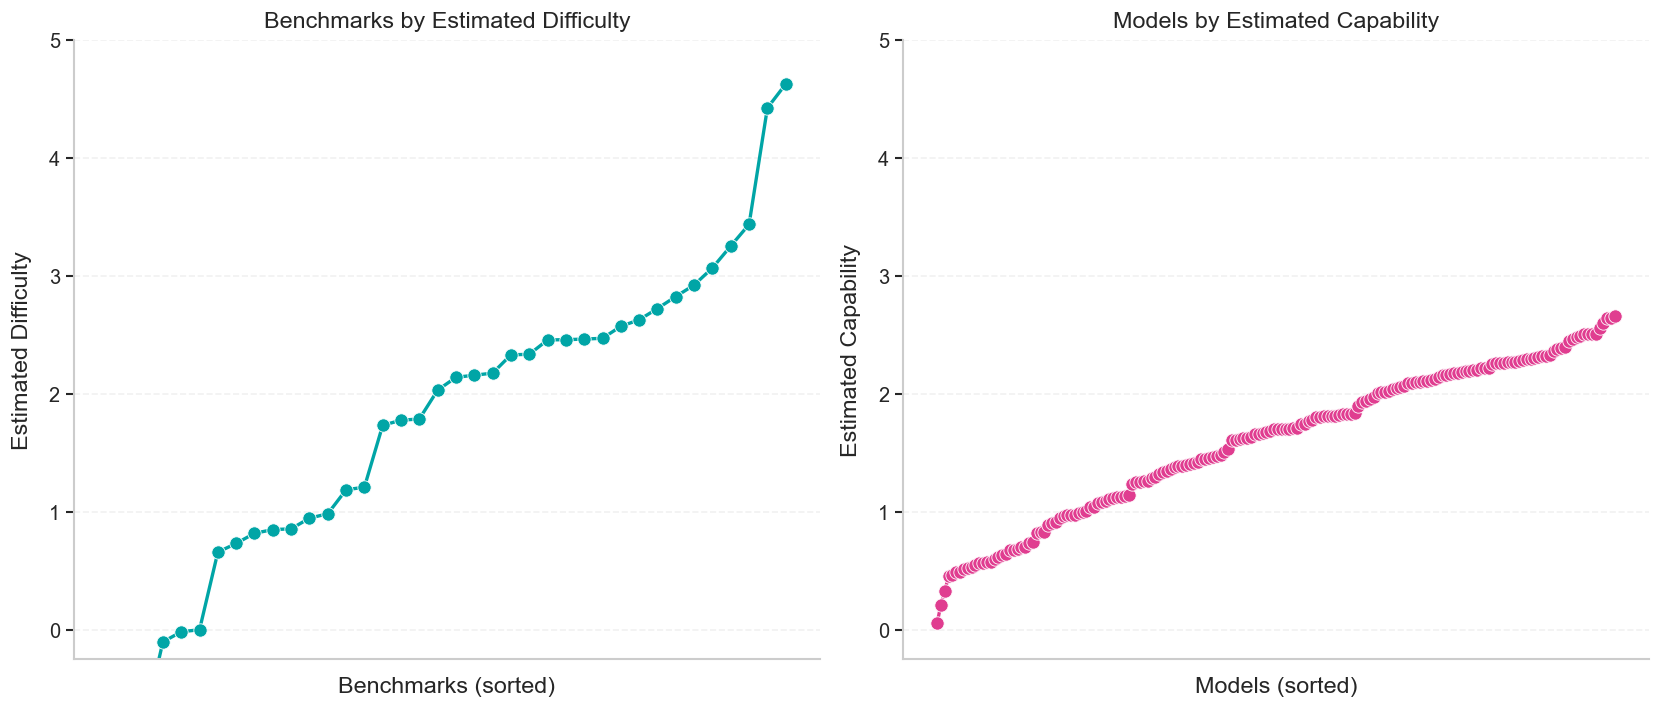

In [26]:
# ---------- 1) Prepare the two ordered data sets ----------
# ------------- (exactly as in your originals) -------------
sorted_bd = df_db1.sort_values(by="estimated_difficulty").reset_index(drop=True)
bd_values  = sorted_bd["estimated_difficulty"]
bd_names   = sorted_bd["benchmark_name"]
bd_ids     = sorted_bd["benchmark_id"]
bd_idx     = np.arange(len(bd_values))

sorted_cm = df_cm1.sort_values(by="estimated_capability").reset_index(drop=True)
cm_values  = sorted_cm["estimated_capability"]
cm_names   = sorted_cm["model"]
cm_ids     = sorted_cm["model_id"]
cm_idx     = np.arange(len(cm_values))

# ---------- 2) Create a single figure with two sub-axes ----------
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 8), sharey=False  # sharey=False because scales differ
)

# ---------- 3) First subplot: benchmark difficulties ----------
ax1.plot(bd_idx, bd_values, marker='o', linestyle='-', linewidth=2,
         markersize=8, markeredgecolor='white', color=colors[0])
ax1.set_xlabel('Benchmarks (sorted)', fontsize=14)
ax1.set_ylabel('Estimated Difficulty', fontsize=14)
ax1.set_title('Benchmarks by Estimated Difficulty')
# ax1.set_xticks(bd_idx)
# ax1.set_xticklabels(bd_ids, rotation=90)
ax1.set_xticks([])
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.axhspan(bd_values.min(), bd_values.max(), alpha=0.1, color='skyblue')

ax1.set_ylim(-0.25, 5)
ax1.tick_params(axis='y', labelsize=12)

# # optional min / max call-outs
# ax1.annotate(f'Min: {bd_values.min():.2f}', xy=(0, bd_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax1.annotate(f'Max: {bd_values.max():.2f}', xy=(len(bd_values)-1, bd_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 4) Second subplot: model capabilities ----------
ax2.plot(cm_idx, cm_values, marker='o', linestyle='-', linewidth=2,
         markersize=8, markeredgecolor='white', color=colors[1])
ax2.set_xlabel('Models (sorted)', fontsize=14)
ax2.set_ylabel('Estimated Capability', fontsize=14)
ax2.set_title('Models by Estimated Capability')
# ax2.set_xticks(cm_idx)
# ax2.set_xticklabels(cm_ids, rotation=90)
ax2.set_xticks([])
ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.axhspan(cm_values.min(), cm_values.max(), alpha=0.1, color='lightgreen')

ax2.set_ylim(-0.25, 5)
ax2.tick_params(axis='y')

# ax2.annotate(f'Min: {cm_values.min():.2f}', xy=(0, cm_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax2.annotate(f'Max: {cm_values.max():.2f}', xy=(len(cm_values)-1, cm_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 5) Finish up ----------
# fig.suptitle('Benchmark Difficulty vs. Model Capability', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for the suptitle
plt.subplots_adjust(bottom=0.25)         # extra space for x-tick labels

plt.savefig("outputs/notebooks/model_and_benchmark_ranking.pdf", dpi=300, bbox_inches='tight')
plt.savefig('outputs/figures/figure-20.svg', format='svg')

plt.show()


In [27]:
set(df1["benchmark"])

{'ANLI',
 'ARC AI2',
 'ARC-AGI',
 'Aider polyglot',
 'BBH',
 'Balrog',
 'CadEval',
 'Cybench',
 'DeepResearch Bench',
 'Factorio learning environment',
 'Fiction.LiveBench',
 'FrontierMath-2025-02-28-Private',
 'FrontierMath-Tier-4-2025-07-01-Private',
 'GPQA diamond',
 'GSM8K',
 'GSO-Bench',
 'GeoBench',
 'HellaSwag',
 'LAMBADA',
 'Lech Mazur Writing',
 'LiveBench',
 'MATH level 5',
 'MMLU',
 'OSUniverse',
 'OSWorld',
 'OTIS Mock AIME 2024-2025',
 'OpenBookQA',
 'PIQA',
 'SWE-Bench verified',
 'ScienceQA',
 'SimpleBench',
 'Terminal Bench',
 'The Agent Company',
 'TriviaQA',
 'VPCT',
 'VideoMME',
 'WeirdML',
 'Winogrande'}

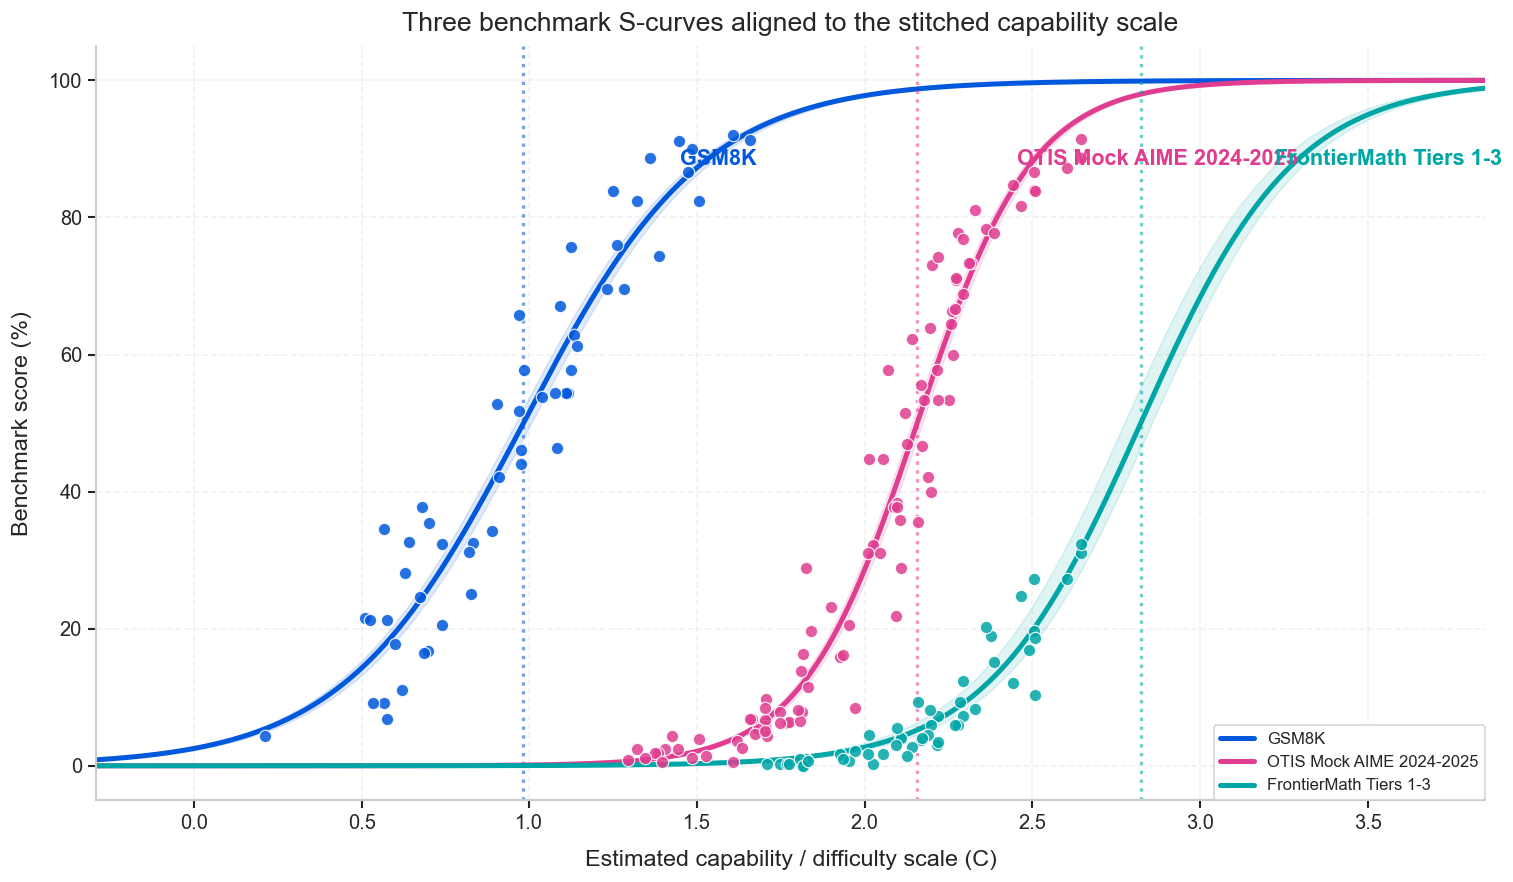

In [47]:
# ── Benchmark S-curves for GSM8K, OTIS Mock AIME, and FrontierMath ──

def _def_logistic(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))

target_benchmarks = [
    {"name": "GSM8K", "label": "GSM8K", "color": colors[4]},
    {"name": "OTIS Mock AIME 2024-2025", "label": "OTIS Mock AIME 2024-2025", "color": colors[1]},
    {"name": "FrontierMath-2025-02-28-Private", "label": "FrontierMath Tiers 1-3", "color": colors[0]},
]

cap_min = df_cm1['estimated_capability'].min()
cap_max = df_cm1['estimated_capability'].max()
x_pad = 0.35
x_grid = np.linspace(cap_min - x_pad, 3.5 + x_pad, 800)

# Lookup table for difficulty error bars if they have been computed earlier
if isinstance(globals().get('difficulty_errors'), pd.DataFrame) and 'benchmark_name' in difficulty_errors.columns:
    difficulty_error_lookup = difficulty_errors.set_index('benchmark_name').to_dict('index')
else:
    difficulty_error_lookup = {}

fig, ax = plt.subplots(figsize=(13, 7.5))

for bench in target_benchmarks:
    bench_row = df_db1[df_db1['benchmark_name'] == bench['name']]
    if bench_row.empty:
        print(f"⚠️ Benchmark '{bench['name']}' not found in df_db1.")
        continue
    params = bench_row.iloc[0]
    D = params['estimated_difficulty']
    alpha = params['estimated_slope']

    bench_scores = (
        df1[df1['benchmark'] == bench['name']]
        .merge(df_cm1[['model', 'estimated_capability']], on='model', how='left')
        .dropna(subset=['performance', 'estimated_capability'])
    )
    if bench_scores.empty:
        print(f"⚠️ No model scores available for '{bench['name']}'.")
        continue

    curve = _def_logistic(alpha * (x_grid - D)) * 100
    ax.plot(x_grid, curve, color=bench['color'], linewidth=3, label=bench['label'])

    err_row = difficulty_error_lookup.get(bench['name'])
    if err_row is not None:
        lower = _def_logistic(alpha * (x_grid - (D + err_row['error_plus']))) * 100
        upper = _def_logistic(alpha * (x_grid - (D - err_row['error_minus']))) * 100
        ax.fill_between(x_grid, lower, upper, color=bench['color'], alpha=0.12)

    ax.scatter(
        bench_scores['estimated_capability'],
        bench_scores['performance'] * 100,
        s=55,
        color=bench['color'],
        edgecolors='white',
        linewidth=0.75,
        alpha=0.85,
        zorder=3,
    )

    ax.axvline(D, color=bench['color'], linestyle=':', alpha=0.55)

    # Annotate each curve near its high-accuracy region
    try:
        text_x = D + np.log(0.85 / 0.15) / alpha
    except ZeroDivisionError:
        text_x = D
    text_x = np.clip(text_x, x_grid.min(), x_grid.max())
    text_y = _def_logistic(alpha * (text_x - D)) * 100 + 2
    ax.text(
        text_x,
        text_y,
        bench['label'],
        color=bench['color'],
        fontsize=13,
        fontweight='semibold',
        ha='left',
        va='bottom'
    )

ax.set_xlabel('Estimated capability / difficulty scale (C)', fontsize=14)
ax.set_ylabel('Benchmark score (%)', fontsize=14)
ax.set_ylim(-5, 105)
ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_title('Three benchmark S-curves aligned to the stitched capability scale', fontsize=16)
ax.grid(True, which='major', linestyle='--', alpha=0.3)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('outputs/model_fit/three_benchmark_s_curves.svg', dpi=300, bbox_inches='tight')
plt.show()
